### AngleCam V2 TLS reference testing setup

This notebook initializes the environment to test AngleCam V2 outputs against TLS references. Below, we import required packages, and load the pretrained model checkpoint for subsequent evaluation steps.


In [7]:
# Imports and path setup
from __future__ import annotations
import os
from pathlib import Path
from typing import Union, List, Dict, Any, Optional

import numpy as np
import pandas as pd
import torch
import json
from datetime import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from datetime import datetime
import re

# Ensure project root is on sys.path for imports if needed
import sys

PROJECT_ROOT = Path.cwd().parent.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
    
# AngleCam import
from anglecam import AngleCam

# Paths
OUTPUT_DIR = PROJECT_ROOT / "data" / "03_Model_Outputs" / "checkpoint"
CHECKPOINT_PATH = OUTPUT_DIR / "AngleCamV2.pth"

TESTING_CSV = PROJECT_ROOT / "data" / "01_Training_Validation_Data" / "splits" / "testing.csv"
IMAGES_DIR = PROJECT_ROOT / "data" / "01_Training_Validation_Data" / "image_data"

TLS_DIR = PROJECT_ROOT / "data" / "02_Test_Data" / "TLS" / "analysis"

TESTING_DIR_CALATHEA = PROJECT_ROOT / "data" / "02_Test_Data" / "images" / "calathea_ornata"
TESTING_DIR_MARANTA = PROJECT_ROOT / "data" / "02_Test_Data" / "images" / "maranta_leuconeura"
TESTING_DIR_AGLAONEMA = PROJECT_ROOT / "data" / "02_Test_Data" / "images" / "aglaonema_commutatum"

TESTING_RESULTS_DIR = PROJECT_ROOT / "data" / "03_Model_Outputs" / "predictions" / "testing"
FIGURE_OUTPUT_DIR = PROJECT_ROOT / "data" / "other" / "figures" / "results"

# Colors
custom_colors = ["#C2B2B4", "#6B4E71", "#3A4454", "#53687E", "#F5DDDD"]
custom_colors2 = ["#F1F1FE", "#9492B9", "#AFBFCD", "#3A739D", "#ADC0A8"]

# Create color palette
custom_palette = sns.color_palette(custom_colors)
custom_palette2 = sns.color_palette(custom_colors2)

print(f"Using checkpoint: {CHECKPOINT_PATH}")
print(f"Testing CSV:      {TESTING_CSV}")
print(f"Images dir:       {IMAGES_DIR}")

# Basic checks
assert CHECKPOINT_PATH.exists(), f"Checkpoint not found: {CHECKPOINT_PATH}"
assert TESTING_CSV.exists(), f"Testing CSV not found: {TESTING_CSV}"
assert IMAGES_DIR.exists(), f"Images directory not found: {IMAGES_DIR}"
assert TLS_DIR.exists(), f"TLS directory not found: {TLS_DIR}"
assert TESTING_DIR_CALATHEA.exists(), f"Calathea directory not found: {TESTING_DIR_CALATHEA}"
assert TESTING_DIR_MARANTA.exists(), f"Maranta directory not found: {TESTING_DIR_MARANTA}"
assert TESTING_DIR_AGLAONEMA.exists(), f"Aglaonema directory not found: {TESTING_DIR_AGLAONEMA}"


Using checkpoint: /mnt/data/lk1167/projects/AngleCamV2/data/03_Model_Outputs/checkpoint/AngleCamV2.pth
Testing CSV:      /mnt/data/lk1167/projects/AngleCamV2/data/01_Training_Validation_Data/splits/testing.csv
Images dir:       /mnt/data/lk1167/projects/AngleCamV2/data/01_Training_Validation_Data/image_data


### Load the pretrained model

In [5]:
# Load pretrained model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

config_overrides = {
    "training": {
        "output_dir": "data/model/output" 
    }
}

anglecam = AngleCam.from_checkpoint(
    str(CHECKPOINT_PATH), 
    config_overrides=config_overrides
)
anglecam.device = device

# Move model to selected device for later inference
anglecam.model.to(device)

print("Model loaded and ready for inference.")

Using device: cuda:0


Using cache found in /home/lk1167/.cache/torch/hub/facebookresearch_dinov2_main
/home/lk1167/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/lk1167/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/lk1167/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded and ready for inference.


In [6]:
# Check whether the model is working
anglecam.predict(IMAGES_DIR / "01_1_TLC00006_image_000003.png")

{'image_path': '/mnt/data/lk1167/projects/AngleCamV2/data/01_Training_Validation_Data/image_data/01_1_TLC00006_image_000003.png',
 'predicted_mean_leaf_angle': 29.429302235865702,
 'angle_distribution': [0.021772129461169243,
  0.02680359221994877,
  0.030632195994257927,
  0.03698616474866867,
  0.03900669515132904,
  0.04312029108405113,
  0.043422017246484756,
  0.04674513265490532,
  0.04797336831688881,
  0.0430871807038784,
  0.046075448393821716,
  0.04160675033926964,
  0.042223911732435226,
  0.03872132673859596,
  0.03883104771375656,
  0.037691231817007065,
  0.03363949432969093,
  0.03380783274769783,
  0.029584338888525963,
  0.028784360736608505,
  0.027748189866542816,
  0.02629997394979,
  0.022316962480545044,
  0.021917816251516342,
  0.01826983131468296,
  0.01646815985441208,
  0.016091786324977875,
  0.014457442797720432,
  0.012265446595847607,
  0.010529241524636745,
  0.00960592832416296,
  0.008288228884339333,
  0.0071871220134198666,
  0.006555742118507624,
 

In [8]:
with open(TLS_DIR / "calathea_tls_leaf_angle_analysis.json", "r") as f:
    calathea_tls_data = json.load(f)

with open(TLS_DIR / "maranta_tls_leaf_angle_analysis.json", "r") as f:
    maranta_tls_data = json.load(f)

### Run predictions

In [3]:
# Load testing csv file
testing_df = pd.read_csv(TESTING_CSV)

calathea_df = testing_df[testing_df['plant_name'] == 'Calathea ornata']
maranta_df = testing_df[testing_df['plant_name'] == 'Maranta leuconeura']

In [5]:
calathea_df

,time,filename,tls_filename,plant_name,tls_average_angle
0,17-01-2025 17:38,G5Bullet_55_2025-01-17_17_38_00_corrected.jpg,Scan001_Calathea_250117_173802.las,Calathea ornata,59.565417
1,17-01-2025 18:08,G5Bullet_55_2025-01-17_18_08_00_corrected.jpg,Scan001_Calathea_250117_180802.las,Calathea ornata,59.728907
2,17-01-2025 18:38,G5Bullet_55_2025-01-17_18_38_00_corrected.jpg,Scan001_Calathea_250117_183802.las,Calathea ornata,59.724270
3,17-01-2025 19:08,G5Bullet_55_2025-01-17_19_08_00_corrected.jpg,Scan001_Calathea_250117_190802.las,Calathea ornata,60.678274
4,17-01-2025 19:38,G5Bullet_55_2025-01-17_19_38_00_corrected.jpg,Scan001_Calathea_250117_193802.las,Calathea ornata,61.546587
...,...,...,...,...,...
121,20-01-2025 06:38,G5Bullet_55_2025-01-20_06_38_00_corrected.jpg,Scan001_Calathea_250120_063802.las,Calathea ornata,59.215766
122,20-01-2025 07:08,G5Bullet_55_2025-01-20_07_08_00_corrected.jpg,Scan001_Calathea_250120_070802.las,Calathea ornata,59.263306
123,20-01-2025 07:38,G5Bullet_55_2025-01-20_07_38_00_corrected.jpg,Scan001_Calathea_250120_073802.las,Calathea ornata,59.166974
124,20-01-2025 08:08,G5Bullet_55_2025-01-20_08_08_00_corrected.jpg,Scan001_Calathea_250120_080802.las,Calathea ornata,59.417977


In [92]:
def predict_with_tls_reference(df, anglecam, images_dir, plant_name):
    """
    Perform predictions and compare with TLS reference data.

    Args:
        df: DataFrame with test data (columns: datetime, filename, las_file, plant_name, tls_mean_angle)
        anglecam: Loaded AngleCam model instance
        images_dir: Path to directory containing the images
        plant_name: Name of the plant species

    Returns:
        dict: Contains prediction results, reference data, and comparison metrics
    """
    results = {
        "predictions": [],
        "summary": {},
        "metadata": {
            "total_samples": len(df),
            "plant_species": plant_name,
            "prediction_timestamp": pd.Timestamp.now().isoformat(),
        },
    }

    # Collect data for batch processing
    image_paths = []
    reference_means = []

    for idx, row in df.iterrows():
        image_path = images_dir / row["filename"]
        if image_path.exists():
            image_paths.append(str(image_path))
            reference_means.append(row["tls_average_angle"])
        else:
            print(f"Warning: Image not found: {image_path}")

    print(f"Processing {len(image_paths)} images...")

    # Perform batch prediction with reference values
    prediction_results = anglecam.predict(image_paths, reference_mean=reference_means)

    # Process results
    predicted_angles = []
    reference_angles = []
    errors = []
    absolute_errors = []

    for i, pred_result in enumerate(prediction_results):
        if "error" not in pred_result:
            # Get corresponding row data
            row = df.iloc[i]

            # Store individual result
            result_entry = {
                "datetime": row["time"],
                "filename": row["filename"],
                "las_file": row["tls_filename"],
                "predicted_mean_angle": pred_result["predicted_mean_leaf_angle"],
                "reference_mean_angle": pred_result["reference_mean_leaf_angle"],
                "prediction_error": pred_result["prediction_error"],
                "absolute_error": pred_result["absolute_error"],
                "angle_distribution": pred_result["angle_distribution"],
                "image_path": pred_result["image_path"],
            }
            results["predictions"].append(result_entry)

            # Collect for summary statistics
            predicted_angles.append(pred_result["predicted_mean_leaf_angle"])
            reference_angles.append(pred_result["reference_mean_leaf_angle"])
            errors.append(pred_result["prediction_error"])
            absolute_errors.append(pred_result["absolute_error"])
        else:
            print(
                f"Prediction error for {pred_result['image_path']}: {pred_result['error']}"
            )

    # Calculate summary statistics
    if predicted_angles:
        predicted_angles = np.array(predicted_angles)
        reference_angles = np.array(reference_angles)
        errors = np.array(errors)
        absolute_errors = np.array(absolute_errors)

        # Basic statistics
        results["summary"] = {
            "n_successful_predictions": len(predicted_angles),
            "n_failed_predictions": len(prediction_results) - len(predicted_angles),
            # Prediction statistics
            "predicted_mean": float(np.mean(predicted_angles)),
            "predicted_std": float(np.std(predicted_angles)),
            "predicted_min": float(np.min(predicted_angles)),
            "predicted_max": float(np.max(predicted_angles)),
            # Reference statistics
            "reference_mean": float(np.mean(reference_angles)),
            "reference_std": float(np.std(reference_angles)),
            "reference_min": float(np.min(reference_angles)),
            "reference_max": float(np.max(reference_angles)),
            # Error statistics
            "mean_error": float(np.mean(errors)),
            "std_error": float(np.std(errors)),
            "mean_absolute_error": float(np.mean(absolute_errors)),
            "rmse": float(np.sqrt(np.mean(errors**2))),
            # Correlation and agreement
            "correlation": float(np.corrcoef(predicted_angles, reference_angles)[0, 1]),
            "r_squared": float(
                np.corrcoef(predicted_angles, reference_angles)[0, 1] ** 2
            ),
            # Angle range statistics
            "predicted_range": float(
                np.max(predicted_angles) - np.min(predicted_angles)
            ),
            "reference_range": float(
                np.max(reference_angles) - np.min(reference_angles)
            ),
        }

        print(f"\n=== Prediction Summary ===")
        print(
            f"Successful predictions: {results['summary']['n_successful_predictions']}"
        )
        print(f"Mean Absolute Error: {results['summary']['mean_absolute_error']:.2f}°")
        print(f"RMSE: {results['summary']['rmse']:.2f}°")
        print(f"Correlation (r): {results['summary']['correlation']:.3f}")
        print(f"R²: {results['summary']['r_squared']:.3f}")
        print(
            f"Predicted range: {results['summary']['predicted_min']:.1f}° - {results['summary']['predicted_max']:.1f}°"
        )
        print(
            f"Reference range: {results['summary']['reference_min']:.1f}° - {results['summary']['reference_max']:.1f}°"
        )

    return results


def predict_directory_images_fast(
    images_dir: Union[str, Path], 
    anglecam, 
    plant_name: Optional[str] = None,
    batch_size: int = 64
) -> Dict[str, Any]:
    """
    Fast batch processing that truly processes images in parallel.
    """
    import torch
    from PIL import Image
    import time
    from pathlib import Path
    
    images_dir = Path(images_dir)
    
    if not images_dir.exists():
        raise ValueError(f"Directory not found: {images_dir}")
    
    # Find all images
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(list(images_dir.glob(ext)))
    
    if not image_paths:
        raise ValueError(f"No supported image files found in directory: {images_dir}")
    
    image_paths = sorted(image_paths)
    
    print(f"Found {len(image_paths)} images")
    print(f"Processing with true batch size {batch_size}...")
    
    # Ensure predictor exists to get transform
    if anglecam.predictor is None:
        from anglecam.inference.predictor import AngleCamPredictor
        anglecam.predictor = AngleCamPredictor(
            model=anglecam.model,
            config=anglecam.config,
            device=anglecam.device,
            logger=anglecam.logger,
        )
    
    # Get transform
    transform = anglecam.predictor.transform
    
    # Results storage
    results = {
        "predictions": [],
        "summary": {},
        "metadata": {
            "total_images_found": len(image_paths),
            "images_directory": str(images_dir),
            "plant_species": plant_name,
            "prediction_timestamp": pd.Timestamp.now().isoformat(),
            "batch_size": batch_size
        },
    }
    
    predicted_angles = []
    successful_predictions = 0
    failed_predictions = 0
    start_time = time.time()
    
    # Set model to eval mode
    anglecam.model.eval()
    
    # Process in true batches
    with torch.no_grad():
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            
            # Load and preprocess batch of images
            batch_tensors = []
            valid_paths = []
            
            for path in batch_paths:
                try:
                    # Load image
                    image = Image.open(path).convert("RGB")
                    
                    # Apply transform
                    if hasattr(transform, "__call__"):
                        # Albumentations
                        transformed = transform(image=np.array(image))
                        tensor = transformed["image"]
                    else:
                        # Torchvision
                        tensor = transform(image)
                    
                    batch_tensors.append(tensor)
                    valid_paths.append(path)
                    
                except Exception as e:
                    print(f"Failed to load {path.name}: {e}")
                    failed_predictions += 1
            
            if not batch_tensors:
                continue
                
            # Stack into batch tensor
            batch_tensor = torch.stack(batch_tensors).to(anglecam.device)
            
            try:
                # Single forward pass for entire batch
                outputs = anglecam.model(batch_tensor)
                probabilities_batch = outputs.cpu().numpy()
                
                # Process results
                for j, (probabilities, path) in enumerate(zip(probabilities_batch, valid_paths)):
                    try:
                        # Calculate angle statistics
                        angle_stats = anglecam.predictor._probabilities_to_stats(probabilities)
                        
                        result_entry = {
                            "filename": path.name,
                            "image_path": str(path),
                            "predicted_mean_angle": angle_stats["mean_angle"],
                            "angle_distribution": probabilities.tolist(),
                        }
                        results["predictions"].append(result_entry)
                        predicted_angles.append(angle_stats["mean_angle"])
                        successful_predictions += 1
                        
                    except Exception as e:
                        print(f"Error processing result for {path.name}: {e}")
                        failed_predictions += 1
                        
            except Exception as e:
                print(f"Batch inference failed: {e}")
                failed_predictions += len(batch_tensors)
            
            # Progress update
            elapsed = time.time() - start_time
            processed = min(i + batch_size, len(image_paths))
            rate = processed / elapsed if elapsed > 0 else 0
            eta = (len(image_paths) - processed) / rate if rate > 0 else 0
            
            print(f"Processed {processed}/{len(image_paths)} images "
                  f"({rate:.1f} img/s, ETA: {eta:.1f}s)")
    
    processing_time = time.time() - start_time
    
    # Calculate summary statistics
    if predicted_angles:
        predicted_angles = np.array(predicted_angles)
        
        results["summary"] = {
            "n_successful_predictions": successful_predictions,
            "n_failed_predictions": failed_predictions,
            "success_rate": successful_predictions / len(image_paths),
            "processing_time_seconds": processing_time,
            "images_per_second": len(image_paths) / processing_time,
            
            "predicted_mean": float(np.mean(predicted_angles)),
            "predicted_std": float(np.std(predicted_angles)),
            "predicted_min": float(np.min(predicted_angles)),
            "predicted_max": float(np.max(predicted_angles)),
            "predicted_median": float(np.median(predicted_angles)),
            "predicted_range": float(np.max(predicted_angles) - np.min(predicted_angles)),
            "predicted_25th_percentile": float(np.percentile(predicted_angles, 25)),
            "predicted_75th_percentile": float(np.percentile(predicted_angles, 75)),
        }
        
        print(f"Total time: {processing_time:.2f}s")
        print(f"Speed: {results['summary']['images_per_second']:.1f} images/second")
        print(f"Successful: {successful_predictions}/{len(image_paths)} ({results['summary']['success_rate']:.1%})")
        print(f"Mean angle: {results['summary']['predicted_mean']:.2f}°")
        
    else:
        results["summary"] = {
            "n_successful_predictions": 0,
            "n_failed_predictions": failed_predictions,
            "success_rate": 0.0,
            "processing_time_seconds": processing_time,
            "images_per_second": 0.0
        }
    
    return results

In [11]:
# Calathea ornata testing inference
calathea_results = predict_with_tls_reference(calathea_df, anglecam, TESTING_DIR_CALATHEA, "Calathea ornata")

Processing 126 images...



=== Prediction Summary ===
Successful predictions: 126
Mean Absolute Error: 5.04°
RMSE: 5.95°
Correlation (r): 0.719
R²: 0.517
Predicted range: 45.7° - 61.6°
Reference range: 50.0° - 62.4°


In [ ]:
# Maranta leuconeura testing inference
maranta_results = predict_with_tls_reference(maranta_df, anglecam, TESTING_DIR_MARANTA, "Maranta leuconeura")

Processing 127 images...

=== Prediction Summary ===
Successful predictions: 127
Mean Absolute Error: 2.63°
RMSE: 3.25°
Correlation (r): 0.865
R²: 0.749
Predicted range: 42.4° - 65.1°
Reference range: 41.2° - 64.5°


In [94]:
aglaonema_results = predict_directory_images_fast(
    images_dir=TESTING_DIR_AGLAONEMA,
    anglecam=anglecam,
    plant_name="Aglaonema commutatum",
    batch_size=128 # Start with 64, increase if GPU memory allows
)

Found 8783 images
Processing with true batch size 128...


Processed 128/8783 images (49.0 img/s, ETA: 176.5s)
Processed 256/8783 images (47.7 img/s, ETA: 178.8s)
Processed 384/8783 images (45.5 img/s, ETA: 184.5s)
Processed 512/8783 images (44.7 img/s, ETA: 185.2s)
Processed 640/8783 images (44.3 img/s, ETA: 184.0s)
Processed 768/8783 images (44.1 img/s, ETA: 181.8s)
Processed 896/8783 images (44.7 img/s, ETA: 176.5s)
Processed 1024/8783 images (44.7 img/s, ETA: 173.4s)
Processed 1152/8783 images (44.3 img/s, ETA: 172.1s)
Processed 1280/8783 images (44.4 img/s, ETA: 169.1s)
Processed 1408/8783 images (44.7 img/s, ETA: 165.0s)
Processed 1536/8783 images (44.7 img/s, ETA: 162.1s)
Processed 1664/8783 images (45.0 img/s, ETA: 158.2s)
Processed 1792/8783 images (45.0 img/s, ETA: 155.5s)
Processed 1920/8783 images (44.7 img/s, ETA: 153.5s)
Processed 2048/8783 images (44.6 img/s, ETA: 151.2s)
Processed 2176/8783 images (44.4 img/s, ETA: 148.9s)
Processed 2304/8783 images (44.5 img/s, ETA: 145.5s)
Processed 2432/8783 images (44.8 img/s, ETA: 141.9s)


In [27]:
# Save json file
def save_prediction_results(
    results_dict: dict, species_name: str, output_dir: str = "data/results/predictions"
) -> Path:
    """
    Save prediction results to JSON file.

    Args:
        results_dict: Results dictionary from predict_directory_images
        species_name: Name of the plant species
        output_dir: Directory to save the file

    Returns:
        Path to saved file
    """
    import json
    from pathlib import Path

    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Validate results structure
    required_keys = ["predictions", "summary", "metadata"]
    if not all(key in results_dict for key in required_keys):
        raise ValueError(f"Results dict missing required keys: {required_keys}")

    # Create filename
    filename = f"{species_name.lower().replace(' ', '_')}_predictions.json"
    filepath = output_path / filename

    # Save with pretty formatting
    with open(filepath, "w") as f:
        json.dump(results_dict, f, indent=2, ensure_ascii=False)

    print(
        f"Saved {len(results_dict['predictions'])} predictions for {species_name} to {filepath}"
    )

    return filepath


# Usage:
#calathea_file = save_prediction_results(calathea_results, "Calathea ornata", TESTING_RESULTS_DIR)
maranta_file = save_prediction_results(maranta_results, "Maranta leuconeura", TESTING_RESULTS_DIR)
aglaonema_file = save_prediction_results(aglaonema_results, "Aglaonema commutatum", TESTING_RESULTS_DIR)

Saved 127 predictions for Maranta leuconeura to /mnt/data/lk1167/projects/AngleCamV2/data/inference/results/maranta_leuconeura_predictions_no_normalization.json
Saved 8783 predictions for Aglaonema commutatum to /mnt/data/lk1167/projects/AngleCamV2/data/inference/results/aglaonema_commutatum_predictions_no_normalization.json


### Load predictions

In [9]:
with open(TESTING_RESULTS_DIR / "calathea_ornata_predictions.json", "r") as f:
    calathea_results = json.load(f)

with open(TESTING_RESULTS_DIR / "maranta_leuconeura_predictions.json", "r") as f:
    maranta_results = json.load(f)

with open(TESTING_RESULTS_DIR / "aglaonema_commutatum_predictions.json", "r") as f:
    aglaonema_results = json.load(f)

In [11]:
def prepare_plot_data(results):
    """
    Extract plotting data from results list.
    """
    data = []
    
    for result in results['predictions']: 
        data.append({
            'filename': result['filename'],
            'predicted_mean_angle': result['predicted_mean_angle'],
            'reference_mean_angle': result['reference_mean_angle'],
            'timestamp': datetime.strptime(result['datetime'], "%d-%m-%Y %H:%M")
        })
    
    return pd.DataFrame(data)

### Testing result calathea ornata

/tmp/ipykernel_459811/666630034.py:323: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


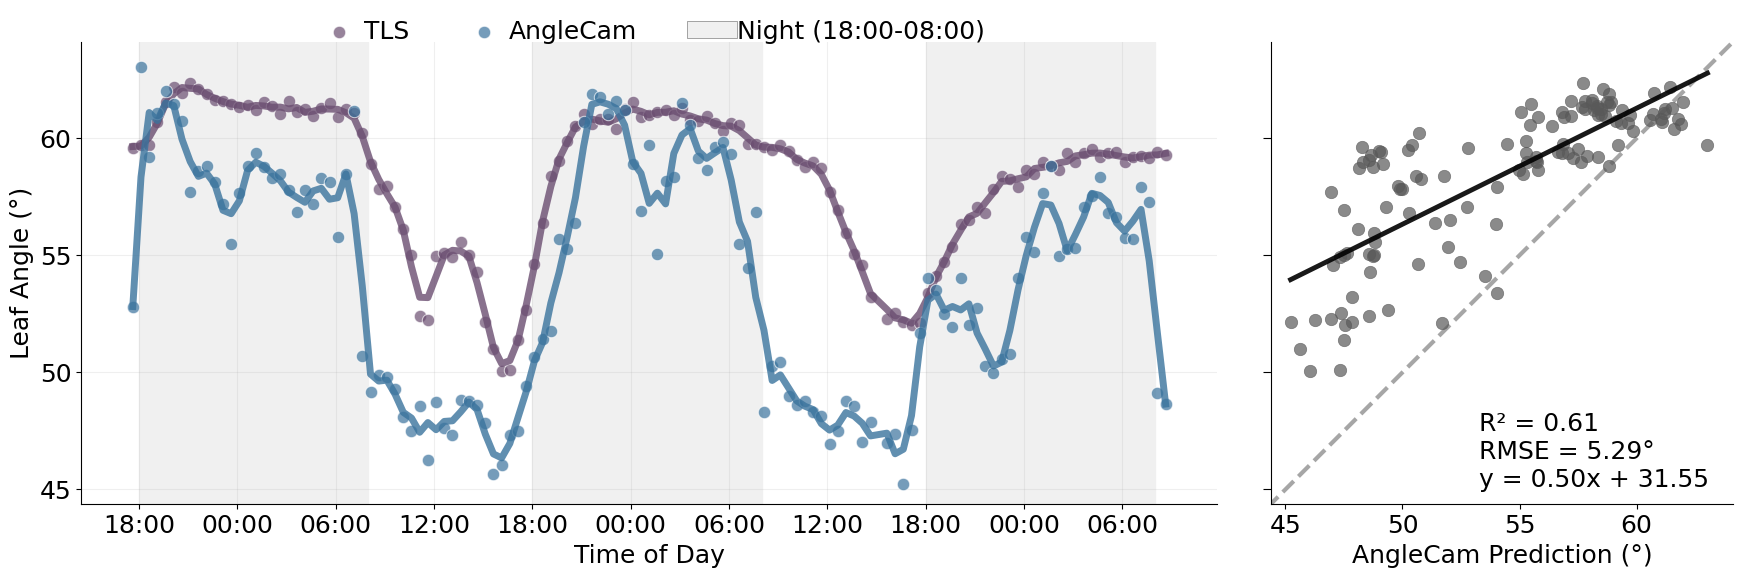

In [12]:
# Enhanced plotting function with day/night visualization
plot_df = prepare_plot_data(calathea_results)

# Set all plotting parameters at the beginning for clarity and reproducibility
FIGURE_SIZE = (22, 6)
ROLLING_WINDOW = 3
MARKER_SIZE = 80
LINE_WIDTH = 5
ALPHA_SCATTER = 0.7
ALPHA_GRID = 0.2
ROTATION_ANGLE = 0

# Font sizes
XLABEL_FONTSIZE = 18
YLABEL_FONTSIZE = 18
LEGEND_FONTSIZE = 18
TICK_LABELSIZE = 18

# Colors for time series
ANGLECAM_COLOR = custom_palette2[3]
ANGLECAM_LINE_COLOR = custom_palette2[3]
TLS_COLOR = custom_palette[1]
TLS_LINE_COLOR = custom_palette[1]

# Day/Night visualization parameters
NIGHT_COLOR = '#f0f0f0'  # Light grey for night background
NIGHT_ALPHA = 1.0
DAY_START_HOUR = 8  # 08:00 - when RGB images typically show daylight effects
DAY_END_HOUR = 18   # 18:00 - when night period begins

# Time axis formatting
HOUR_INTERVALS = [0, 6, 12, 18]
TIME_FORMAT = "%H:%M"

# Scatter plot parameters
SCATTER_MARKER_SIZE = 80
SCATTER_ALPHA = 0.7
ALPHA_REF_LINE = 0.99
ALPHA_FIT_LINE = 0.9
EDGE_LINE_WIDTH = 0.5
REF_LINE_WIDTH = 3
FIT_LINE_WIDTH = 3.5

# Scatter plot colors
SCATTER_COLOR = "#595959"
REF_LINE_COLOR = "#a5a5a5"
FIT_LINE_COLOR = "black"

# Statistics text box positioning
STATS_X_POS = 0.45
STATS_Y_POS = 0.2

# Line styles
REF_LINE_STYLE = "--"
FIT_LINE_STYLE = "--"

# Tick spacing
TICK_SPACING = 5

# Regression line points for smooth consecutive line
REGRESSION_POINTS = 100

# Plot spacing and width ratios
WIDTH_RATIOS = [2, 1]  # Time series : Scatter plot ratio
SUBPLOT_SPACING = 0.001  # Distance between plots

# Create figure with 1 row, 2 columns with custom width ratios and spacing
fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=FIGURE_SIZE,
    gridspec_kw={"width_ratios": WIDTH_RATIOS, "wspace": SUBPLOT_SPACING},
)

# LEFT PLOT: Time series with day/night background
time_data = plot_df.dropna(subset=["timestamp"]).sort_values("timestamp")

# Add day/night background shading
time_min = time_data["timestamp"].min()
time_max = time_data["timestamp"].max()

# Create night period spans for each day in the dataset
import pandas as pd
from datetime import datetime, time

# Get all unique dates in the dataset
dates = pd.to_datetime(time_data["timestamp"]).dt.date.unique()

for date in dates:
    # Convert date to datetime for the start of the day
    day_start = pd.Timestamp.combine(date, time(0, 0))
    day_end = pd.Timestamp.combine(date, time(23, 59, 59))
    
    # Define night periods: 00:00-08:00 and 18:00-24:00
    night_start_early = day_start
    night_end_early = pd.Timestamp.combine(date, time(DAY_START_HOUR, 0))
    
    night_start_late = pd.Timestamp.combine(date, time(DAY_END_HOUR, 0))
    night_end_late = day_end
    
    # Only shade if the night period overlaps with our data range
    if night_end_early >= time_min and night_start_early <= time_max:
        ax1.axvspan(
            max(night_start_early, time_min), 
            min(night_end_early, time_max),
            color=NIGHT_COLOR, 
            alpha=NIGHT_ALPHA, 
            zorder=0
        )
    
    if night_end_late >= time_min and night_start_late <= time_max:
        ax1.axvspan(
            max(night_start_late, time_min), 
            min(night_end_late, time_max),
            color=NIGHT_COLOR, 
            alpha=NIGHT_ALPHA, 
            zorder=0
        )

# Plot TLS standard angles
sns.scatterplot(
    data=time_data,
    x="timestamp",
    y="reference_mean_angle",
    marker="o",
    color=TLS_COLOR,
    label="TLS",
    alpha=ALPHA_SCATTER,
    s=MARKER_SIZE,
    ax=ax1,
    zorder=3
)

# Add smoothed TLS moving average
time_data["reference_mean_angle_smooth"] = (
    time_data["reference_mean_angle"]
    .rolling(window=ROLLING_WINDOW, center=True, min_periods=1)
    .mean()
)

# Plot the smoothed TLS moving average
sns.lineplot(
    data=time_data,
    x="timestamp",
    y="reference_mean_angle_smooth",
    color=TLS_LINE_COLOR,
    linewidth=LINE_WIDTH,
    alpha=0.8,
    ax=ax1,
    zorder=3
)

# Plot predicted angles
sns.scatterplot(
    data=time_data,
    x="timestamp",
    y="predicted_mean_angle",
    marker="o",
    color=ANGLECAM_COLOR,
    label="AngleCam",
    alpha=ALPHA_SCATTER,
    s=MARKER_SIZE,
    ax=ax1,
    zorder=3
)

# Calculate smoothed predicted mean angle
time_data["predicted_mean_angle_smooth"] = (
    time_data["predicted_mean_angle"]
    .rolling(window=ROLLING_WINDOW, center=True, min_periods=1)
    .mean()
)

if len(time_data) > 0:
    time_data.iloc[0, time_data.columns.get_loc("predicted_mean_angle_smooth")] = (
        time_data.iloc[0]["predicted_mean_angle"]
    )
    time_data.iloc[-1, time_data.columns.get_loc("predicted_mean_angle_smooth")] = (
        time_data.iloc[-1]["predicted_mean_angle"]
    )

sns.lineplot(
    data=time_data,
    x="timestamp",
    y="predicted_mean_angle_smooth",
    color=ANGLECAM_LINE_COLOR,
    linewidth=LINE_WIDTH,
    alpha=0.8,
    ax=ax1,
    zorder=3
)

ax1.grid(True, alpha=ALPHA_GRID)

# Create custom legend that includes day/night explanation
from matplotlib.patches import Rectangle
legend_elements = ax1.get_legend_handles_labels()
# Add night period indicator to legend
night_patch = Rectangle((0, 0), 1, 1, facecolor=NIGHT_COLOR, alpha=NIGHT_ALPHA, 
                       edgecolor='grey', linewidth=0.5)
legend_elements[0].append(night_patch)
legend_elements[1].append('Night (18:00-08:00)')

ax1.legend(
    legend_elements[0], legend_elements[1],
    fontsize=LEGEND_FONTSIZE, 
    frameon=False, 
    ncol=3, 
    borderaxespad=0, 
    handletextpad=0.0,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.07)
)

# Set time formatting for x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter(TIME_FORMAT))
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=HOUR_INTERVALS))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=ROTATION_ANGLE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.tick_params(axis="both", which="major", labelsize=TICK_LABELSIZE)

ax1.set_xlabel("Time of Day", fontsize=XLABEL_FONTSIZE)
ax1.set_ylabel("Leaf Angle (°)", fontsize=YLABEL_FONTSIZE)

# Calculate y-axis limits for alignment
y_min = min(
    time_data["predicted_mean_angle_smooth"].min(),
    time_data["reference_mean_angle_smooth"].min(),
)
y_max = max(
    time_data["predicted_mean_angle_smooth"].max(),
    time_data["reference_mean_angle_smooth"].max(),
)
y_margin = 0.25 * (y_max - y_min)
y_lim_min = y_min - y_margin
y_lim_max = y_max + y_margin

ax1.set_ylim(y_lim_min + 2, y_lim_max - 2)

# RIGHT PLOT: Scatter plot 
# Filter out any NaN values
valid_data = plot_df.dropna(subset=["predicted_mean_angle", "reference_mean_angle"])

x = valid_data["predicted_mean_angle"]  # AngleCam predictions on x-axis
y = valid_data["reference_mean_angle"]  # TLS on y-axis

# Add 1:1 reference line
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax2.plot(
    [min_val - 1, max_val + 1],
    [min_val - 1, max_val + 1],
    REF_LINE_STYLE,
    color=REF_LINE_COLOR,
    alpha=ALPHA_REF_LINE,
    linewidth=REF_LINE_WIDTH,
    label="1:1 line",
    zorder=1,
)

# Create scatter plot
ax2.scatter(
    x,
    y,
    alpha=SCATTER_ALPHA,
    s=SCATTER_MARKER_SIZE,
    color=SCATTER_COLOR,
    edgecolors=SCATTER_COLOR,
    linewidth=EDGE_LINE_WIDTH,
)

# Add regression line - create consecutive x values for smooth line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_line = np.linspace(x.min(), x.max(), REGRESSION_POINTS)
ax2.plot(
    x_line,
    p(x_line),
    "-",
    alpha=ALPHA_FIT_LINE,
    linewidth=FIT_LINE_WIDTH,
    label=f"Fit: y = {z[0]:.2f}x + {z[1]:.2f}",
    color=FIT_LINE_COLOR,
)

# Calculate metrics
r2 = np.corrcoef(x, y)[0, 1] ** 2
rmse = np.sqrt(np.mean((y - x) ** 2))

# Add statistics text box
stats_text = f"R² = {r2:.2f}\nRMSE = {rmse:.2f}°\ny = {z[0]:.2f}x + {z[1]:.2f}"
ax2.text(
    STATS_X_POS,
    STATS_Y_POS,
    stats_text,
    transform=ax2.transAxes,
    fontsize=TICK_LABELSIZE,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.0, edgecolor="grey"),
)

ax2.grid(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Set tick spacing to every 5 degrees
ax2.xaxis.set_major_locator(MultipleLocator(TICK_SPACING))
ax2.yaxis.set_major_locator(MultipleLocator(TICK_SPACING))
ax2.tick_params(axis="both", which="major", labelsize=TICK_LABELSIZE)
ax2.set_aspect("equal", adjustable="box")
ax2.tick_params(axis="y", labelleft=False, length=6)

# Align y-axis limits between both plots
ax2.set_ylim(y_lim_min + 2, y_lim_max - 2)
ax2.set_xlim(y_lim_min + 2, y_lim_max - 2)

ax1.set_yticks([45, 50, 55, 60])
ax2.set_yticks([45, 50, 55, 60])

ax2.set_xlabel("AngleCam Prediction (°)", fontsize=XLABEL_FONTSIZE)

plt.tight_layout()

# Save figure
plt.savefig(
    FIGURE_OUTPUT_DIR / "calathea_combined_plot.png", dpi=600, bbox_inches="tight"
)

plt.show()

#### Distributions AngleCam and TLS

In [ ]:
def get_closest_angle_distribution(data_list, target_time_str='18-01-2025 14:38'):
    """
    Find the filename closest to the target time and return its angle_distribution.
    
    Args:
        data_list: List of dictionaries with 'filename' and 'angle_distribution' keys
        target_time_str: Target time in format 'DD-MM-YYYY HH:MM'
    
    Returns:
        List: angle_distribution from the closest time match
    """
    target_time = datetime.strptime(target_time_str, '%d-%m-%Y %H:%M')
    
    def parse_filename_timestamp(filename):
        """Parse timestamp from filename like 'Scan001_Calathea_250118_040802.las'"""
        match = re.search(r'(\d{6})_(\d{6})', filename)
        if not match:
            return None
        
        date_part, time_part = match.groups()
        year = 2000 + int(date_part[:2])
        month = int(date_part[2:4])
        day = int(date_part[4:6])
        hour = int(time_part[:2])
        minute = int(time_part[2:4])
        second = int(time_part[4:6])
        
        return datetime(year, month, day, hour, minute, second)
    
    closest_item = None
    min_diff = float('inf')
    
    for item in data_list:
        file_time = parse_filename_timestamp(item['filename'])
        if file_time is None:
            continue
        
        time_diff = abs((file_time - target_time).total_seconds())
        
        if time_diff < min_diff:
            min_diff = time_diff
            closest_item = item
    
    if closest_item is None:
        return None
    
    return closest_item['angle_distribution']

In [139]:
# Get the predicted distribution from the results
lad_calathea = calathea_results['predictions'][42]["angle_distribution"]
lad_tls = get_closest_angle_distribution(calathea_tls_data['results'], '18-01-2025 14:38')

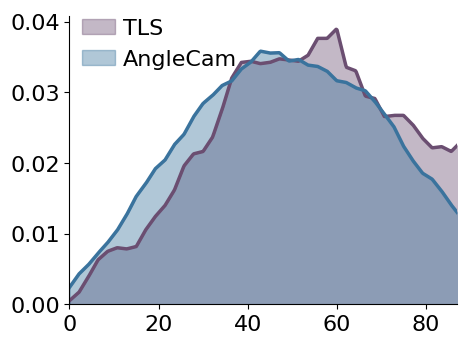

In [141]:
def plot_distributions(pred_lad, tls_lad, save_path=None):
    """Plot smoothed predicted vs TLS distributions"""
    from scipy.interpolate import interp1d

    # Get data
    pred_dist = np.array(pred_lad)
    tls_dist = np.array(tls_lad)

    # Normalize
    pred_dist = pred_dist / np.sum(pred_dist) if np.sum(pred_dist) > 0 else pred_dist
    tls_dist = tls_dist / np.sum(tls_dist) if np.sum(tls_dist) > 0 else tls_dist

    # Smooth slighty with moving average for better visualization
    window = 3
    pred_smooth = np.convolve(pred_dist, np.ones(window) / window, mode="same")
    tls_smooth = np.convolve(tls_dist, np.ones(window) / window, mode="same")

    # Interpolate
    angles = np.linspace(0, 90, 43)
    angles_fine = np.linspace(0, 90, 500)
    pred_interp = interp1d(
        angles, pred_smooth, kind="linear", bounds_error=False, fill_value=0
    )(angles_fine)
    tls_interp = interp1d(
        angles, tls_smooth, kind="linear", bounds_error=False, fill_value=0
    )(angles_fine)

    # Plot
    width = 5
    fig, ax = plt.subplots(figsize=(width, width * 0.75))
    ax.fill_between(angles_fine, tls_interp, alpha=0.4, color=custom_palette[1], label="TLS")
    ax.plot(angles_fine, tls_interp, color=custom_palette[1], linewidth=2.5)
    ax.fill_between(
        angles_fine, pred_interp, alpha=0.4, color=custom_palette2[3], label="AngleCam"
    )
    ax.plot(angles_fine, pred_interp, color=custom_palette2[3], linewidth=2.5)

    ax.legend(
        fontsize=16,
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(-0.02, 1.06),
        handlelength=1.5,
        handletextpad=0.35,
    )
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(0, 87)
    ax.set_ylim(0, None)
    ax.tick_params(axis="both", which="major", labelsize=16)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


save_path = FIGURE_OUTPUT_DIR / "calathea_anglecam_tls_distribution_comparison.png"

# Usage
plot_distributions(lad_calathea, lad_tls[2:], save_path)

### Testing results maranta leuconeura

/tmp/ipykernel_2707701/3236174841.py:319: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


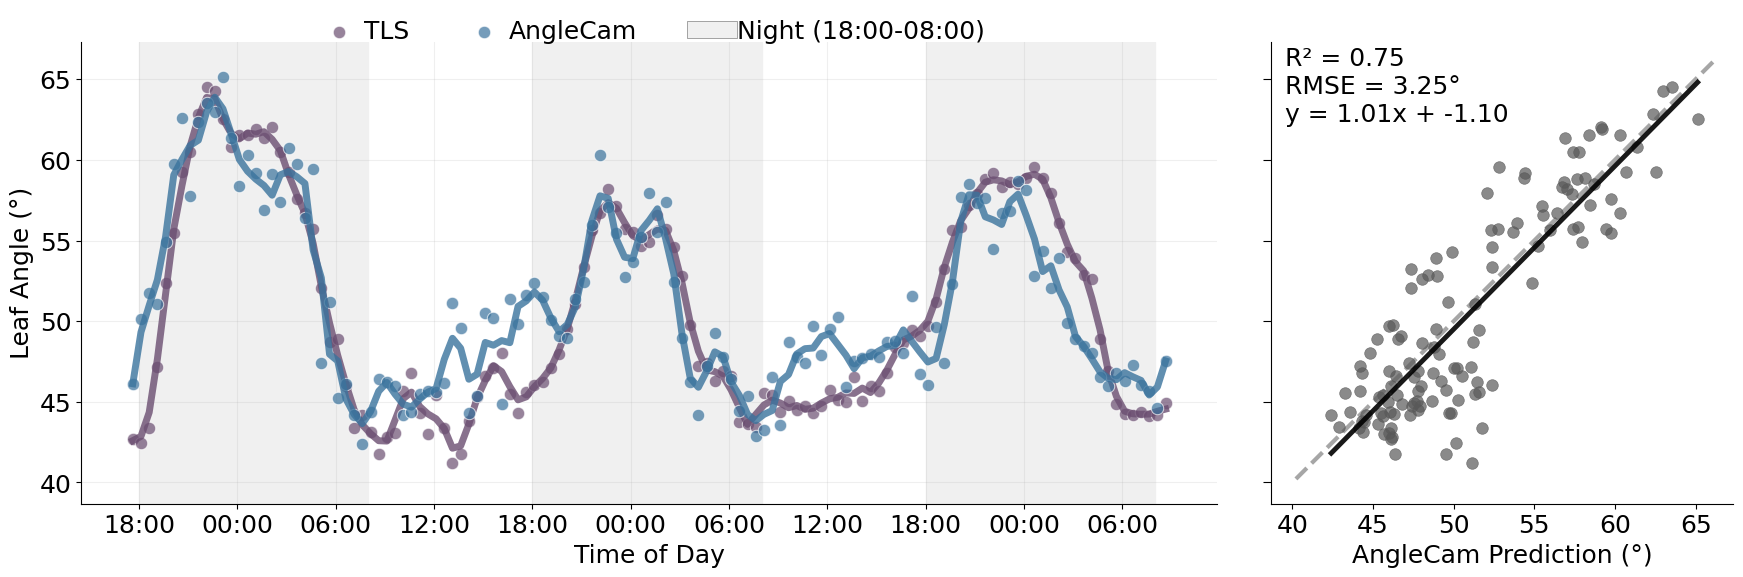

In [32]:
plot_df = prepare_plot_data(maranta_results)

# Set all plotting parameters at the beginning for clarity and reproducibility
FIGURE_SIZE = (22, 6)
ROLLING_WINDOW = 3
MARKER_SIZE = 80
LINE_WIDTH = 5
ALPHA_SCATTER = 0.7
ALPHA_GRID = 0.2
ROTATION_ANGLE = 0

# Font sizes
XLABEL_FONTSIZE = 18
YLABEL_FONTSIZE = 18
LEGEND_FONTSIZE = 18
TICK_LABELSIZE = 18

# Colors for time series
ANGLECAM_COLOR = custom_palette2[3]
ANGLECAM_LINE_COLOR = custom_palette2[3]
TLS_COLOR = custom_palette[1]
TLS_LINE_COLOR = custom_palette[1]

# Day/Night visualization parameters
NIGHT_COLOR = '#f0f0f0'  # Light grey for night background
NIGHT_ALPHA = 1.0
DAY_START_HOUR = 8  # 08:00 - when RGB images typically show daylight effects
DAY_END_HOUR = 18   # 18:00 - when night period begins

# Time axis formatting
HOUR_INTERVALS = [0, 6, 12, 18]
TIME_FORMAT = "%H:%M"

# Scatter plot parameters
SCATTER_MARKER_SIZE = 70
SCATTER_ALPHA = 0.7
ALPHA_REF_LINE = 0.99
ALPHA_FIT_LINE = 0.9
EDGE_LINE_WIDTH = 0.5
REF_LINE_WIDTH = 3
FIT_LINE_WIDTH = 3.5

# Scatter plot colors
SCATTER_COLOR = "#595959"
REF_LINE_COLOR = "#a5a5a5"
FIT_LINE_COLOR = "black"

# Statistics text box positioning
STATS_X_POS = 0.03
STATS_Y_POS = 0.99

# Line styles
REF_LINE_STYLE = "--"
FIT_LINE_STYLE = "--"

# Tick spacing
TICK_SPACING = 5

# Regression line points for smooth consecutive line
REGRESSION_POINTS = 100

# Plot spacing and width ratios
WIDTH_RATIOS = [2, 1]  # Time series : Scatter plot ratio
SUBPLOT_SPACING = 0.001  # Distance between plots

# Create figure with 1 row, 2 columns with custom width ratios and spacing
fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=FIGURE_SIZE,
    gridspec_kw={"width_ratios": WIDTH_RATIOS, "wspace": SUBPLOT_SPACING},
)

# LEFT PLOT: Time series with day/night background
time_data = plot_df.dropna(subset=["timestamp"]).sort_values("timestamp")

# Add day/night background shading
time_min = time_data["timestamp"].min()
time_max = time_data["timestamp"].max()

# Create night period spans for each day in the dataset
import pandas as pd
from datetime import datetime, time

# Get all unique dates in the dataset
dates = pd.to_datetime(time_data["timestamp"]).dt.date.unique()

for date in dates:
    # Convert date to datetime for the start of the day
    day_start = pd.Timestamp.combine(date, time(0, 0))
    day_end = pd.Timestamp.combine(date, time(23, 59, 59))
    
    # Define night periods: 00:00-08:00 and 18:00-24:00
    night_start_early = day_start
    night_end_early = pd.Timestamp.combine(date, time(DAY_START_HOUR, 0))
    
    night_start_late = pd.Timestamp.combine(date, time(DAY_END_HOUR, 0))
    night_end_late = day_end
    
    # Only shade if the night period overlaps with our data range
    if night_end_early >= time_min and night_start_early <= time_max:
        ax1.axvspan(
            max(night_start_early, time_min), 
            min(night_end_early, time_max),
            color=NIGHT_COLOR, 
            alpha=NIGHT_ALPHA, 
            zorder=0
        )
    
    if night_end_late >= time_min and night_start_late <= time_max:
        ax1.axvspan(
            max(night_start_late, time_min), 
            min(night_end_late, time_max),
            color=NIGHT_COLOR, 
            alpha=NIGHT_ALPHA, 
            zorder=0
        )

# Plot TLS standard angles
sns.scatterplot(
    data=time_data,
    x="timestamp",
    y="reference_mean_angle",
    marker="o",
    color=TLS_COLOR,
    label="TLS",
    alpha=ALPHA_SCATTER,
    s=MARKER_SIZE,
    ax=ax1,
    zorder=3
)

# Add smoothed TLS moving average
time_data["reference_mean_angle_smooth"] = (
    time_data["reference_mean_angle"]
    .rolling(window=ROLLING_WINDOW, center=True, min_periods=1)
    .mean()
)

# Plot the smoothed TLS moving average
sns.lineplot(
    data=time_data,
    x="timestamp",
    y="reference_mean_angle_smooth",
    color=TLS_LINE_COLOR,
    linewidth=LINE_WIDTH,
    alpha=0.8,
    ax=ax1,
    zorder=3
)

# Plot predicted angles
sns.scatterplot(
    data=time_data,
    x="timestamp",
    y="predicted_mean_angle",
    marker="o",
    color=ANGLECAM_COLOR,
    label="AngleCam",
    alpha=ALPHA_SCATTER,
    s=MARKER_SIZE,
    ax=ax1,
    zorder=3
)

# Calculate smoothed predicted mean angle
time_data["predicted_mean_angle_smooth"] = (
    time_data["predicted_mean_angle"]
    .rolling(window=ROLLING_WINDOW, center=True, min_periods=1)
    .mean()
)

if len(time_data) > 0:
    time_data.iloc[0, time_data.columns.get_loc("predicted_mean_angle_smooth")] = (
        time_data.iloc[0]["predicted_mean_angle"]
    )
    time_data.iloc[-1, time_data.columns.get_loc("predicted_mean_angle_smooth")] = (
        time_data.iloc[-1]["predicted_mean_angle"]
    )

sns.lineplot(
    data=time_data,
    x="timestamp",
    y="predicted_mean_angle_smooth",
    color=ANGLECAM_LINE_COLOR,
    linewidth=LINE_WIDTH,
    alpha=0.8,
    ax=ax1,
    zorder=3
)

ax1.grid(True, alpha=ALPHA_GRID)

# Create custom legend that includes day/night explanation
from matplotlib.patches import Rectangle
legend_elements = ax1.get_legend_handles_labels()
# Add night period indicator to legend
night_patch = Rectangle((0, 0), 1, 1, facecolor=NIGHT_COLOR, alpha=NIGHT_ALPHA, 
                       edgecolor='grey', linewidth=0.5)
legend_elements[0].append(night_patch)
legend_elements[1].append('Night (18:00-08:00)')

ax1.legend(
    legend_elements[0], legend_elements[1],
    fontsize=LEGEND_FONTSIZE, 
    frameon=False, 
    ncol=3, 
    borderaxespad=0, 
    handletextpad=0.0,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.07)
)

# Set time formatting for x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter(TIME_FORMAT))
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=HOUR_INTERVALS))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=ROTATION_ANGLE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.tick_params(axis="both", which="major", labelsize=TICK_LABELSIZE)

ax1.set_xlabel("Time of Day", fontsize=XLABEL_FONTSIZE)
ax1.set_ylabel("Leaf Angle (°)", fontsize=YLABEL_FONTSIZE)

# Calculate y-axis limits for alignment
y_min = min(
    time_data["predicted_mean_angle_smooth"].min(),
    time_data["reference_mean_angle_smooth"].min(),
)
y_max = max(
    time_data["predicted_mean_angle_smooth"].max(),
    time_data["reference_mean_angle_smooth"].max(),
)
y_margin = 0.25 * (y_max - y_min)
y_lim_min = y_min - y_margin
y_lim_max = y_max + y_margin

ax1.set_ylim(y_lim_min + 2, y_lim_max - 2)

# RIGHT PLOT: Scatter plot (unchanged)
# Filter out any NaN values
valid_data = plot_df.dropna(subset=["predicted_mean_angle", "reference_mean_angle"])

x = valid_data["predicted_mean_angle"]  # AngleCam predictions on x-axis
y = valid_data["reference_mean_angle"]  # TLS on y-axis

# Add 1:1 reference line
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
ax2.plot(
    [min_val - 1, max_val + 1],
    [min_val - 1, max_val + 1],
    REF_LINE_STYLE,
    color=REF_LINE_COLOR,
    alpha=ALPHA_REF_LINE,
    linewidth=REF_LINE_WIDTH,
    label="1:1 line",
    zorder=1,
)

# Create scatter plot
ax2.scatter(
    x,
    y,
    alpha=SCATTER_ALPHA,
    s=SCATTER_MARKER_SIZE,
    color=SCATTER_COLOR,
    edgecolors=SCATTER_COLOR,
    linewidth=EDGE_LINE_WIDTH,
)

# Add regression line - create consecutive x values for smooth line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_line = np.linspace(x.min(), x.max(), REGRESSION_POINTS)
ax2.plot(
    x_line,
    p(x_line),
    "-",
    alpha=ALPHA_FIT_LINE,
    linewidth=FIT_LINE_WIDTH,
    label=f"Fit: y = {z[0]:.2f}x + {z[1]:.2f}",
    color=FIT_LINE_COLOR,
)

# Calculate metrics
r2 = np.corrcoef(x, y)[0, 1] ** 2
rmse = np.sqrt(np.mean((y - x) ** 2))

# Add statistics text box
stats_text = f"R² = {r2:.2f}\nRMSE = {rmse:.2f}°\ny = {z[0]:.2f}x + {z[1]:.2f}"
ax2.text(
    STATS_X_POS,
    STATS_Y_POS,
    stats_text,
    transform=ax2.transAxes,
    fontsize=TICK_LABELSIZE,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.0, edgecolor="grey"),
)

ax2.grid(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Set tick spacing to every 5 degrees
ax2.xaxis.set_major_locator(MultipleLocator(TICK_SPACING))
ax2.yaxis.set_major_locator(MultipleLocator(TICK_SPACING))
ax2.tick_params(axis="both", which="major", labelsize=TICK_LABELSIZE)
ax2.set_aspect("equal", adjustable="box")
ax2.tick_params(axis="y", labelleft=False, length=6)

# Align y-axis limits between both plots
ax2.set_ylim(y_lim_min + 2, y_lim_max - 2)
ax2.set_xlim(y_lim_min + 2, y_lim_max - 2)

ax2.set_xlabel("AngleCam Prediction (°)", fontsize=XLABEL_FONTSIZE)

plt.tight_layout()

# Save figure
plt.savefig(
    FIGURE_OUTPUT_DIR / "maranta_combined_plot.png", dpi=600, bbox_inches="tight"
)

plt.show()

#### Distributions AngleCam and TLS

In [95]:
def get_closest_angle_distribution(data_list, target_time_str='18-01-2025 14:38'):
    """
    Find the filename closest to the target time and return its angle_distribution.
    
    Args:
        data_list: List of dictionaries with 'filename' and 'angle_distribution' keys
        target_time_str: Target time in format 'DD-MM-YYYY HH:MM'
    
    Returns:
        List: angle_distribution from the closest time match
    """
    target_time = datetime.strptime(target_time_str, '%d-%m-%Y %H:%M')
    
    def parse_filename_timestamp(filename):
        """Parse timestamp from filename like 'Scan001_Calathea_250118_040802.las'"""
        match = re.search(r'(\d{6})_(\d{6})', filename)
        if not match:
            return None
        
        date_part, time_part = match.groups()
        year = 2000 + int(date_part[:2])
        month = int(date_part[2:4])
        day = int(date_part[4:6])
        hour = int(time_part[:2])
        minute = int(time_part[2:4])
        second = int(time_part[4:6])
        
        return datetime(year, month, day, hour, minute, second)
    
    closest_item = None
    min_diff = float('inf')
    
    for item in data_list:
        file_time = parse_filename_timestamp(item['filename'])
        if file_time is None:
            continue
        
        time_diff = abs((file_time - target_time).total_seconds())
        
        if time_diff < min_diff:
            min_diff = time_diff
            closest_item = item
    
    if closest_item is None:
        return None
    
    return closest_item['angle_distribution']

In [142]:
# Get the predicted distribution from the results
lad_maranta = maranta_results['predictions'][109]["angle_distribution"]
lad_tls = get_closest_angle_distribution(maranta_tls_data['results'], '20-01-2025 00:08')

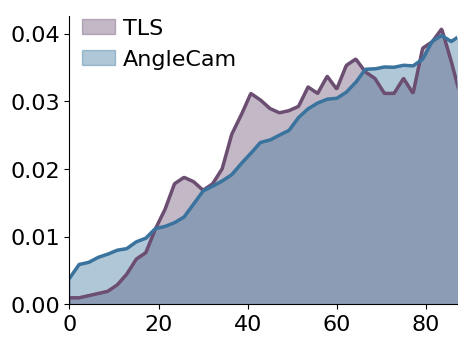

In [143]:
def plot_distributions(pred_lad, tls_lad, save_path=None):
    """Plot smoothed predicted vs TLS distributions"""
    from scipy.interpolate import interp1d

    # Get data
    pred_dist = np.array(pred_lad)
    tls_dist = np.array(tls_lad)

    # Normalize
    pred_dist = pred_dist / np.sum(pred_dist) if np.sum(pred_dist) > 0 else pred_dist
    tls_dist = tls_dist / np.sum(tls_dist) if np.sum(tls_dist) > 0 else tls_dist

    # Smooth slighty with moving average for better visualization
    window = 3
    pred_smooth = np.convolve(pred_dist, np.ones(window) / window, mode="same")
    tls_smooth = np.convolve(tls_dist, np.ones(window) / window, mode="same")

    # Interpolate
    angles = np.linspace(0, 90, 43)
    angles_fine = np.linspace(0, 90, 500)
    pred_interp = interp1d(
        angles, pred_smooth, kind="linear", bounds_error=False, fill_value=0
    )(angles_fine)
    tls_interp = interp1d(
        angles, tls_smooth, kind="linear", bounds_error=False, fill_value=0
    )(angles_fine)

    # Plot
    width = 5
    fig, ax = plt.subplots(figsize=(width, width * 0.75))
    ax.fill_between(
        angles_fine, tls_interp, alpha=0.4, color=custom_palette[1], label="TLS"
    )
    ax.plot(angles_fine, tls_interp, color=custom_palette[1], linewidth=2.5)
    ax.fill_between(
        angles_fine, pred_interp, alpha=0.4, color=custom_palette2[3], label="AngleCam"
    )
    ax.plot(angles_fine, pred_interp, color=custom_palette2[3], linewidth=2.5)

    ax.legend(
        fontsize=16,
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(-0.02, 1.06),
        handlelength=1.5,
        handletextpad=0.35,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlim(0, 87)
    ax.set_ylim(0, None)
    ax.tick_params(axis="both", which="major", labelsize=16)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


save_path = FIGURE_OUTPUT_DIR / "maranta_anglecam_tls_distribution_comparison.png"

# Usage
plot_distributions(lad_maranta, lad_tls[2:], save_path)

### Testing results aglaonema commutatum

In [6]:
def extract_timestamp_from_filename(filename: str) -> datetime:
    """
    Extract timestamp from filename pattern: G5Bullet_57_2024-12-24_00_49_45_corrected.jpg
    Returns datetime object
    """
    # Pattern to match: YYYY-MM-DD_HH_MM_SS
    pattern = r'(\d{4}-\d{2}-\d{2})_(\d{2})_(\d{2})_(\d{2})'
    match = re.search(pattern, filename)
    
    if match:
        date_part = match.group(1)
        hour = match.group(2)
        minute = match.group(3)
        second = match.group(4)
        
        timestamp_str = f"{date_part} {hour}:{minute}:{second}"
        return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
    else:
        raise ValueError(f"Could not extract timestamp from filename: {filename}")
    
extract_timestamp_from_filename("G5Bullet_57_2024-12-24_00_49_45_corrected.jpg")

datetime.datetime(2024, 12, 24, 0, 49, 45)


=== Linear Trend Analysis ===
Slope: 0.327 degrees/day
R²: 0.296
Correlation: 0.544
P-value: 0.000e+00
Trend: increasing (significant)
Plot saved to: /mnt/data/lk1167/projects/AngleCamV2/data/figures/results/aglaonema_anglecam_time_series.png


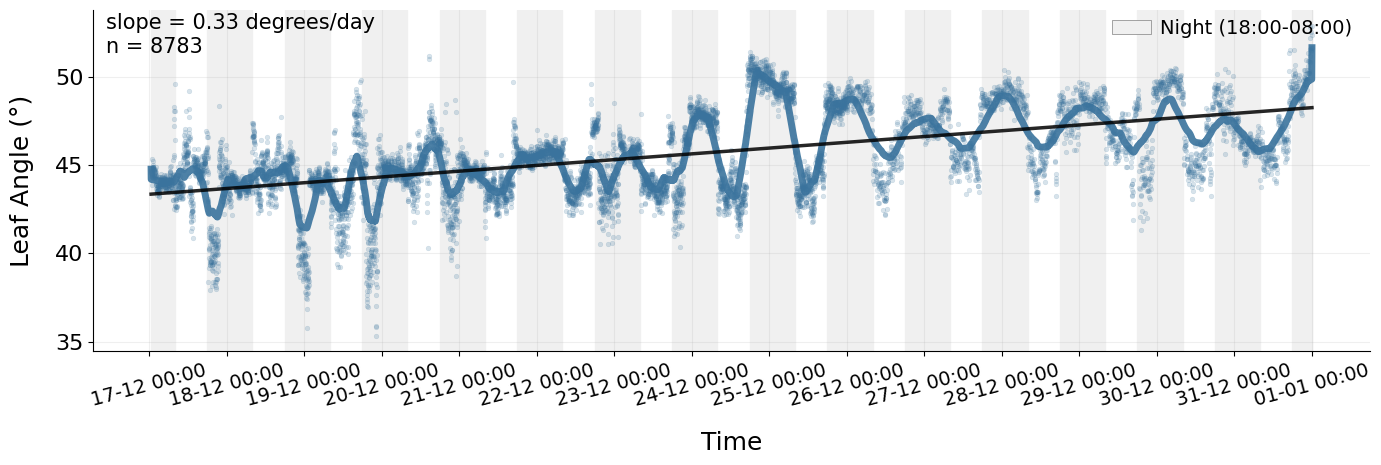

Time series data shape: (8783, 7)
Time range: 2024-12-17 00:37:57 to 2025-01-01 00:04:00
Angle range: 35.3° to 52.9°


In [ ]:
def extract_timestamp_from_filename(filename: str) -> datetime:
    """
    Extract timestamp from filename pattern: G5Bullet_57_2024-12-24_00_49_45_corrected.jpg
    Returns datetime object
    """
    # Pattern to match: YYYY-MM-DD_HH_MM_SS
    pattern = r'(\d{4}-\d{2}-\d{2})_(\d{2})_(\d{2})_(\d{2})'
    match = re.search(pattern, filename)
    
    if match:
        date_part = match.group(1)
        hour = match.group(2)
        minute = match.group(3)
        second = match.group(4)
        
        timestamp_str = f"{date_part} {hour}:{minute}:{second}"
        return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
    else:
        raise ValueError(f"Could not extract timestamp from filename: {filename}")
    

def add_linear_trend_analysis(time_data: pd.DataFrame, plot_trend: bool = True):
    """
    Add linear trend analysis to time series data.
    
    Args:
        time_data: DataFrame with timestamp and predicted_mean_angle columns
        plot_trend: Whether to plot the trend line
        
    Returns:
        dict: Trend analysis results
    """
    from scipy import stats
    import numpy as np
    
    # Convert timestamps to numeric values for regression
    time_numeric = pd.to_numeric(time_data['timestamp']) / 1e9  # Convert to seconds
    angles = time_data['predicted_mean_angle'].values
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_numeric, angles)
    
    # Calculate trend line
    trend_line = slope * time_numeric + intercept
    time_data['linear_trend'] = trend_line
    
    # Convert slope to degrees per day
    slope_per_day = slope * 86400  # seconds per day
    
    # Calculate trend statistics
    trend_results = {
        'slope_degrees_per_second': slope,
        'slope_degrees_per_day': slope_per_day,
        'intercept': intercept,
        'r_squared': r_value**2,
        'correlation': r_value,
        'p_value': p_value,
        'standard_error': std_err,
        'trend_direction': 'increasing' if slope > 0 else 'decreasing' if slope < 0 else 'stable',
        'significance': 'significant' if p_value < 0.05 else 'not significant'
    }
    
    # Print trend summary
    print(f"\n=== Linear Trend Analysis ===")
    print(f"Slope: {slope_per_day:.3f} degrees/day")
    print(f"R²: {trend_results['r_squared']:.3f}")
    print(f"Correlation: {trend_results['correlation']:.3f}")
    print(f"P-value: {p_value:.3e}")
    print(f"Trend: {trend_results['trend_direction']} ({trend_results['significance']})")
    
    return trend_results, time_data


def create_time_series_plot(results_df: pd.DataFrame, output_path: str = "", title: str = "AngleCam Time Series"):
    """
    Create time series plot from inference results with day/night visualization
    
    Args:
        results_df: DataFrame with inference results
        output_path: Path to save the plot
        title: Plot title
    """
    
    # Extract timestamps and create time series data
    time_data = results_df.copy()
    time_data['timestamp'] = time_data['filename'].apply(extract_timestamp_from_filename)
    time_data = time_data.sort_values('timestamp')
    
    # Add linear trend analysis
    trend_results, time_data = add_linear_trend_analysis(time_data)
    
    # Set plotting parameters (same as reference)
    FIGURE_SIZE = (14, 5)
    ROLLING_WINDOW = 90*2
    MARKER_SIZE = 12
    LINE_WIDTH = 5
    ALPHA_SCATTER = 0.2
    ALPHA_GRID = 0.2
    ROTATION_ANGLE = 15
    
    # Day/Night visualization parameters
    NIGHT_COLOR = '#f0f0f0'  # Light grey for night background
    NIGHT_ALPHA = 1.0
    DAY_START_HOUR = 8  # 08:00 - when RGB images typically show daylight effects
    DAY_END_HOUR = 18   # 18:00 - when night period begins
    
    # Font sizes
    XLABEL_FONTSIZE = 18
    YLABEL_FONTSIZE = 18
    LEGEND_FONTSIZE = 14
    TICK_LABELSIZE = 16
    
    # Colors
    ANGLECAM_COLOR = custom_palette2[3]
    ANGLECAM_LINE_COLOR = custom_palette2[3]
    TREND_COLOR = 'black'  # Black for trend line
    
    # Time axis formatting
    HOUR_INTERVALS = [0]
    TIME_FORMAT = '%d-%m %H:%M'
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    
    # Add day/night background shading
    time_min = time_data["timestamp"].min()
    time_max = time_data["timestamp"].max()
    
    # Create night period spans for each day in the dataset
    import pandas as pd
    from datetime import datetime, time
    
    # Get all unique dates in the dataset
    dates = pd.to_datetime(time_data["timestamp"]).dt.date.unique()
    
    for date in dates:
        # Convert date to datetime for the start of the day
        day_start = pd.Timestamp.combine(date, time(0, 0))
        day_end = pd.Timestamp.combine(date, time(23, 59, 59))
        
        # Define night periods: 00:00-08:00 and 18:00-24:00
        night_start_early = day_start
        night_end_early = pd.Timestamp.combine(date, time(DAY_START_HOUR, 0))
        
        night_start_late = pd.Timestamp.combine(date, time(DAY_END_HOUR, 0))
        night_end_late = day_end
        
        # Only shade if the night period overlaps with our data range
        if night_end_early >= time_min and night_start_early <= time_max:
            ax.axvspan(
                max(night_start_early, time_min), 
                min(night_end_early, time_max),
                color=NIGHT_COLOR, 
                alpha=NIGHT_ALPHA, 
                zorder=0
            )
        
        if night_end_late >= time_min and night_start_late <= time_max:
            ax.axvspan(
                max(night_start_late, time_min), 
                min(night_end_late, time_max),
                color=NIGHT_COLOR, 
                alpha=NIGHT_ALPHA, 
                zorder=0
            )
    
    # Plot predicted angles (no label to avoid in legend)
    sns.scatterplot(
        data=time_data,
        x='timestamp',
        y='predicted_mean_angle',
        marker='o',
        color=ANGLECAM_COLOR,
        edgecolor=ANGLECAM_COLOR,
        alpha=ALPHA_SCATTER,
        s=MARKER_SIZE,
        ax=ax,
        zorder=3
    )
    
    # Calculate and plot smoothed predicted mean angle (no label to avoid in legend)
    time_data['predicted_mean_angle_smooth'] = time_data['predicted_mean_angle'].rolling(
        window=ROLLING_WINDOW, center=True, min_periods=1
    ).mean()
    
    # Ensure first and last values are preserved
    if len(time_data) > 0:
        time_data.iloc[0, time_data.columns.get_loc('predicted_mean_angle_smooth')] = time_data.iloc[0]['predicted_mean_angle']
        time_data.iloc[-1, time_data.columns.get_loc('predicted_mean_angle_smooth')] = time_data.iloc[-1]['predicted_mean_angle']
    
    sns.lineplot(
        data=time_data,
        x='timestamp',
        y='predicted_mean_angle_smooth',
        color=ANGLECAM_LINE_COLOR,
        linewidth=LINE_WIDTH,
        alpha=0.9,
        ax=ax,
        zorder=3
    )
    
    # Plot linear trend line (no label to avoid in legend)
    sns.lineplot(
        data=time_data,
        x='timestamp',
        y='linear_trend',
        color=TREND_COLOR,
        linewidth=2.5,
        alpha=0.85,
        linestyle='-',
        ax=ax,
        zorder=3
    )
    
    # Add regression statistics text box
    n_samples = len(time_data)
    r_squared = trend_results['r_squared']
    slope_per_day = trend_results['slope_degrees_per_day']
    intercept = trend_results['intercept']
    p_value = trend_results['p_value']
    
    # Format equation
    sign = '+' if intercept >= 0 else '-'
    equation = f"y = {slope_per_day:.3f}t {sign} {abs(intercept):.1f}"
    
    # Create statistics text
    stats_text = (
        f"slope = {slope_per_day:.2f} degrees/day\n"
        f"n = {n_samples}\n"
    )
    
    # Add text box to plot
    ax.text(0.01, 0.99, stats_text,
            transform=ax.transAxes,
            fontsize=15,
            verticalalignment='top',
            horizontalalignment='left',
            zorder=4)
    
    # Create custom legend with only night period indicator
    from matplotlib.patches import Rectangle
    night_patch = Rectangle((0, 0), 1, 1, facecolor=NIGHT_COLOR, alpha=NIGHT_ALPHA, 
                           edgecolor='grey', linewidth=0.5)
    
    # Create legend with only the night indicator
    ax.legend([night_patch], ['Night (18:00-08:00)'], 
             loc='upper right', 
             fontsize=LEGEND_FONTSIZE, 
             frameon=False,
             handletextpad=0.5,
             bbox_to_anchor=(1.0, 1.025))
    
    # Formatting
    ax.set_xlabel('Time', fontsize=XLABEL_FONTSIZE, labelpad=15)
    ax.set_ylabel('Leaf Angle (°)', fontsize=YLABEL_FONTSIZE, labelpad=15)
    ax.grid(True, alpha=ALPHA_GRID)
    
    # Set time formatting for x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter(TIME_FORMAT))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=ROTATION_ANGLE)
    
    # Y axis ticks every 5 steps
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    
    # Style adjustments
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=TICK_LABELSIZE)
    
    # Set y-axis limits with margin
    y_min = time_data['predicted_mean_angle'].min()
    y_max = time_data['predicted_mean_angle'].max()
    y_margin = 0.05 * (y_max - y_min)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save if path provided
    if output_path:
        plt.savefig(output_path, dpi=400, bbox_inches='tight')
        print(f"Plot saved to: {output_path}")
    
    plt.show()
    
    return time_data

# Create the time series plot for Aglaonema data
output_plot_path = FIGURE_OUTPUT_DIR / "aglaonema_anglecam_time_series.png"

# Make sure the output directory exists
os.makedirs(os.path.dirname(output_plot_path), exist_ok=True)

results_df = pd.DataFrame(aglaonema_results["predictions"])

time_data = create_time_series_plot(
    results_df=results_df,
    output_path=output_plot_path,
    title="Aglaonema AngleCam Time Series"
)

print(f"Time series data shape: {time_data.shape}")
print(f"Time range: {time_data['timestamp'].min()} to {time_data['timestamp'].max()}")
print(f"Angle range: {time_data['predicted_mean_angle'].min():.1f}° to {time_data['predicted_mean_angle'].max():.1f}°")

#### Distributions

In [18]:
# Calculate mean distribution of all predictions
def calculate_mean_distribution(results_df: pd.DataFrame) -> np.ndarray:
    """Calculate the mean distribution across all predicted distributions."""
    valid_distributions = []
    for dist in results_df["angle_distribution"]:
        if dist is not None and len(dist) == 43:
            valid_distributions.append(dist)
    
    if len(valid_distributions) == 0:
        print("Warning: No valid distributions found!")
        return np.zeros(43)
    
    all_distributions = np.array(valid_distributions)
    mean_distribution = np.mean(all_distributions, axis=0)
    mean_distribution = mean_distribution / np.sum(mean_distribution)  # Normalize
    
    print(f"Calculated mean from {len(valid_distributions)} valid distributions")
    return mean_distribution

# Calculate once
mean_distribution = calculate_mean_distribution(results_df)

Calculated mean from 8783 valid distributions


In [28]:
def find_closest_entry(
    results_df: pd.DataFrame, target_datetime: datetime
) -> pd.Series:
    """
    Find the entry closest to the target datetime.

    Args:
        results_df: DataFrame with inference results and timestamps
        target_datetime: Target datetime to find closest entry for

    Returns:
        Series containing the closest entry data
    """
    # Extract timestamps if not already done
    if "timestamp" not in results_df.columns:
        results_df["timestamp"] = results_df["filename"].apply(
            extract_timestamp_from_filename
        )

    # Calculate time differences
    time_diffs = abs(results_df["timestamp"] - target_datetime)
    closest_idx = time_diffs.idxmin()

    closest_entry = results_df.loc[closest_idx]
    actual_time = closest_entry["timestamp"]
    time_diff = abs(actual_time - target_datetime).total_seconds() / 60  # in minutes

    print(f"Target time: {target_datetime}")
    print(f"Closest entry: {actual_time} (diff: {time_diff:.1f} minutes)")
    print(f"Filename: {closest_entry['filename']}")

    return closest_entry


def plot_distribution(
    results_df: pd.DataFrame,
    target_datetimes: List[datetime],
    mean_distribution: np.ndarray = None,
    output_path: str = "",
    color: str = None,
    plot_y_axis: bool = True,
    y_ticks: bool = True,
    window_size: int = 5,
) -> None:
    from scipy.interpolate import interp1d

    # Set plotting parameters
    width = 4
    FIGURE_SIZE = (width, width * 0.75)
    TICK_LABELSIZE = 16

    angles = np.linspace(0, 90, 43)

    # Calculate mean angle from provided mean_distribution (if available)
    if mean_distribution is not None:
        mean_angle_overall = np.sum(mean_distribution * angles)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)

    for i, target_time in enumerate(target_datetimes):
        closest_entry = find_closest_entry(results_df, target_time)
        distribution = np.array(closest_entry["angle_distribution"])
        predicted_mean = closest_entry["predicted_mean_angle"]

        # Apply moving average smoothing
        distribution_ma = np.convolve(
            distribution, np.ones(window_size) / window_size, mode="same"
        )

        f_interp = interp1d(
            angles, distribution_ma, kind="quadratic", bounds_error=False, fill_value=0
        )

        # Create smooth points
        angles_smooth = np.linspace(0, 90, 500)
        distribution_smooth = f_interp(angles_smooth)
        distribution_smooth = np.maximum(distribution_smooth, 0)

        time_label = closest_entry["timestamp"].strftime("%H:%M")

        # Plot filled area
        ax.fill_between(
            angles_smooth,
            distribution_smooth,
            alpha=0.7,
            color=color,
            label=f"{time_label} (mean: {predicted_mean:.1f}°)",
        )

        # Add outline
        ax.plot(
            angles_smooth, distribution_smooth, color=color, linewidth=2.5, alpha=1.0
        )

        # Add mean line
        ax.axvline(
            x=predicted_mean, color=color, linestyle="--", linewidth=2, alpha=0.8
        )

    # Add mean distribution as dashed line
    if mean_distribution is not None:
        # Apply same smoothing to mean distribution
        mean_distribution_ma = np.convolve(
            mean_distribution, np.ones(5) / 5, mode="same"
        )
        f_interp_mean = interp1d(
            angles,
            mean_distribution_ma,
            kind="quadratic",
            bounds_error=False,
            fill_value=0,
        )
        mean_distribution_smooth = f_interp_mean(angles_smooth)
        mean_distribution_smooth = np.maximum(mean_distribution_smooth, 0)

        ax.plot(
            angles_smooth,
            mean_distribution_smooth,
            color="black",
            linestyle="--",
            linewidth=3,
            alpha=0.9,
            label=f"Mean distribution ({mean_angle_overall:.1f}°)",
        )

    # Formatting
    ax.plot([0, 90], [0, 0], color="black", linewidth=2)
    #ax.grid(True, alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", which="major", labelsize=14)
    ax.tick_params(axis="y", which="major", labelsize=TICK_LABELSIZE)
    ax.set_xlim(0, 90)
    ax.set_ylim(0, None)
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    
    # Set only 5 y-axis ticks
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=400, bbox_inches="tight")
        print(f"Plot saved to: {output_path}")
        
    print(f"Mean angle: {predicted_mean:.1f}°")

    plt.show()

Target time: 2024-12-17 01:30:00
Closest entry: 2024-12-17 01:30:00 (diff: 0.0 minutes)
Filename: G5Bullet_57_2024-12-17_01_30_00_corrected.jpg
Plot saved to: /mnt/data/lk1167/projects/AngleCamV2/data/figures/results/aglaonema_distribution_20241217_013000.png
Mean angle: 44.7°


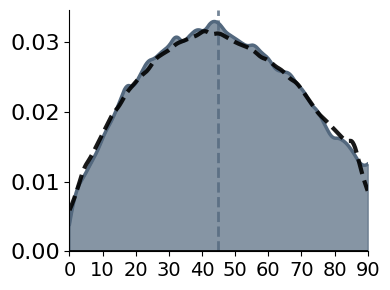

In [31]:
# Distribution plot
target_time = datetime(2024, 12, 17, 1, 30, 0)
output_path_single = FIGURE_OUTPUT_DIR / f"aglaonema_distribution_{target_time.strftime('%Y%m%d_%H%M%S')}.png"

plot_distribution(
    results_df=results_df,
    target_datetimes=[target_time],
    mean_distribution=mean_distribution,
    output_path=output_path_single,
    color=custom_palette[3],
    window_size=2,  
)

Target time: 2024-12-22 11:30:00
Closest entry: 2024-12-22 11:30:00 (diff: 0.0 minutes)
Filename: G5Bullet_57_2024-12-22_11_30_00_corrected.jpg
Plot saved to: /mnt/data/lk1167/projects/AngleCamV2/data/figures/results/aglaonema_distribution_20241222_113000.png
Mean angle: 43.7°


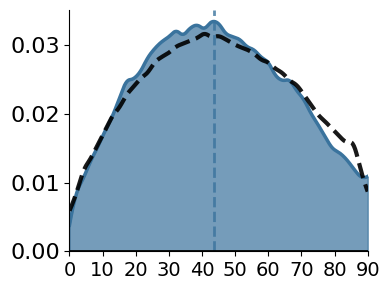

In [32]:
# Distribution plot
target_time = datetime(2024, 12, 22, 11, 30, 0)
output_path_single = FIGURE_OUTPUT_DIR / f"aglaonema_distribution_{target_time.strftime('%Y%m%d_%H%M%S')}.png"

plot_distribution(
    results_df=results_df,
    target_datetimes=[target_time],
    mean_distribution=mean_distribution,
    output_path=output_path_single,
    color=custom_palette2[3],
    window_size=2,  
)

Target time: 2024-12-26 00:00:00
Closest entry: 2024-12-26 00:00:00 (diff: 0.0 minutes)
Filename: G5Bullet_57_2024-12-26_00_00_00_corrected.jpg
Plot saved to: /mnt/data/lk1167/projects/AngleCamV2/data/figures/results/aglaonema_distribution_20241226_000000.png
Mean angle: 49.2°


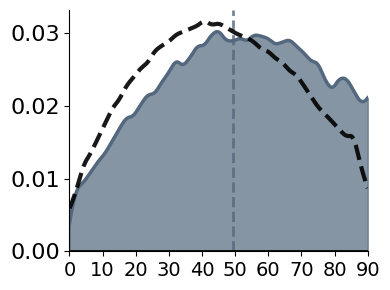

In [33]:
# Distribution plot
target_time = datetime(2024, 12, 26, 0, 0, 0)
output_path_single = FIGURE_OUTPUT_DIR / f"aglaonema_distribution_{target_time.strftime('%Y%m%d_%H%M%S')}.png"

plot_distribution(
    results_df=results_df,
    target_datetimes=[target_time],
    mean_distribution=mean_distribution,
    output_path=output_path_single,
    color=custom_palette[3],
    window_size=2,  
)

Target time: 2024-12-31 14:30:00
Closest entry: 2024-12-31 14:28:00 (diff: 2.0 minutes)
Filename: G5Bullet_57_2024-12-31_14_28_00_corrected.jpg
Plot saved to: /mnt/data/lk1167/projects/AngleCamV2/data/figures/results/aglaonema_distribution_20241231_143000.png
Mean angle: 47.0°


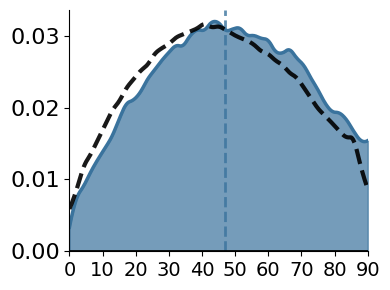

In [34]:
# Distribution plot
target_time = datetime(2024, 12, 31, 14, 30, 0)
output_path_single = FIGURE_OUTPUT_DIR / f"aglaonema_distribution_{target_time.strftime('%Y%m%d_%H%M%S')}.png"

plot_distribution(
    results_df=results_df,
    target_datetimes=[target_time],
    mean_distribution=mean_distribution,
    output_path=output_path_single,
    color=custom_palette2[3],
    window_size=2,  
)

#### LAD variability trend

In [4]:
aglaonema_results

{'predictions': [{'filename': 'G5Bullet_57_2024-12-17_00_37_57_corrected.jpg',
   'image_path': '/mnt/data/lk1167/projects/AngleCamV2/data/images/testing/aglaonema_commutatum/G5Bullet_57_2024-12-17_00_37_57_corrected.jpg',
   'predicted_mean_angle': 44.757086670558365,
   'angle_distribution': [0.008054464124143124,
    0.009689370170235634,
    0.012076562270522118,
    0.013486669398844242,
    0.016044864431023598,
    0.018202126026153564,
    0.019936470314860344,
    0.022928345948457718,
    0.024423491209745407,
    0.023234587162733078,
    0.027492258697748184,
    0.026613635942339897,
    0.02868487685918808,
    0.02835971862077713,
    0.030228352174162865,
    0.0306661706417799,
    0.02922898158431053,
    0.03236713260412216,
    0.030709579586982727,
    0.032223112881183624,
    0.03285406157374382,
    0.03203773871064186,
    0.030418748036026955,
    0.030530869960784912,
    0.029061468318104744,
    0.029450302943587303,
    0.029186828061938286,
    0.02774295

In [6]:
def calculate_distribution_variability_from_dict(results_dict: dict) -> pd.DataFrame:
    """
    Calculate various measures of LAD variability over time from loaded results dictionary.
    
    Args:
        results_dict: Dictionary containing predictions (already loaded from JSON)
    
    Returns:
        DataFrame with timestamp and variability measures
    """
    import numpy as np
    import pandas as pd
    from datetime import datetime
    import re
    from scipy.stats import entropy, skew, kurtosis
    
    def extract_timestamp_from_filename(filename: str) -> datetime:
        """
        Extract timestamp from filename pattern: G5Bullet_57_2024-12-24_00_49_45_corrected.jpg
        Returns datetime object
        """
        # Pattern to match: YYYY-MM-DD_HH_MM_SS
        pattern = r'(\d{4}-\d{2}-\d{2})_(\d{2})_(\d{2})_(\d{2})'
        match = re.search(pattern, filename)
        
        if match:
            date_part = match.group(1)
            hour = match.group(2)
            minute = match.group(3)
            second = match.group(4)
            
            timestamp_str = f"{date_part} {hour}:{minute}:{second}"
            return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
        else:
            raise ValueError(f"Could not extract timestamp from filename: {filename}")
    
    # Extract predictions from the dictionary
    predictions = results_dict['predictions']
    print(f"Found {len(predictions)} predictions in results dictionary")
    
    variability_data = []
    angles = np.linspace(0, 90, 43)  # AngleCam uses 43 bins from 0° to 90°
    
    print("Processing predictions...")
    for i, prediction in enumerate(predictions):
        if i % 1000 == 0:  # Progress indicator
            print(f"Processed {i}/{len(predictions)} predictions...")
        
        try:
            # Extract data from prediction
            filename = prediction['filename']
            mean_angle = prediction['predicted_mean_angle']
            distribution = np.array(prediction['angle_distribution'])
            
            # Ensure distribution is normalized (should sum to 1)
            if np.sum(distribution) > 0:
                distribution = distribution / np.sum(distribution)
            else:
                print(f"Warning: Empty distribution for {filename}")
                continue
            
            # Calculate various variability measures
            variance = np.sum(distribution * (angles - mean_angle) ** 2)
            std_dev = np.sqrt(variance)
            
            # Distribution entropy (higher = more uniform distribution)
            dist_entropy = entropy(distribution + 1e-10)  # Add small epsilon to avoid log(0)
            
            # Distribution skewness (shape asymmetry)
            dist_skewness = skew(distribution)
            
            # Distribution kurtosis (tail heaviness)
            dist_kurtosis = kurtosis(distribution)
            
            # 95% confidence interval width
            try:
                cumulative = np.cumsum(distribution)
                lower_idx = np.where(cumulative >= 0.025)[0][0]
                upper_idx = np.where(cumulative >= 0.975)[0][0]
                ci_width = angles[upper_idx] - angles[lower_idx]
            except (IndexError, ValueError):
                ci_width = np.nan
            
            # Interquartile range
            try:
                cumulative = np.cumsum(distribution)
                q25_idx = np.where(cumulative >= 0.25)[0][0]
                q75_idx = np.where(cumulative >= 0.75)[0][0]
                iqr = angles[q75_idx] - angles[q25_idx]
            except (IndexError, ValueError):
                iqr = np.nan
            
            # Peak height (maximum probability density)
            peak_height = np.max(distribution)
            
            # Mode (angle with highest probability)
            mode_idx = np.argmax(distribution)
            mode_angle = angles[mode_idx]
            
            # Extract timestamp from filename
            timestamp = extract_timestamp_from_filename(filename)
            
            variability_data.append({
                'timestamp': timestamp,
                'filename': filename,
                'mean_angle': mean_angle,
                'std_dev': std_dev,
                'variance': variance,
                'entropy': dist_entropy,
                'skewness': dist_skewness,
                'kurtosis': dist_kurtosis,
                'ci_width': ci_width,
                'iqr': iqr,
                'peak_height': peak_height,
                'mode_angle': mode_angle
            })
            
        except Exception as e:
            print(f"Error processing prediction {i} ({filename}): {str(e)}")
            continue
    
    print(f"Successfully processed {len(variability_data)} predictions")
    
    # Convert to DataFrame and sort by timestamp
    df = pd.DataFrame(variability_data)
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"Mean angle range: {df['mean_angle'].min():.1f}° to {df['mean_angle'].max():.1f}°")
    
    return df

In [20]:
def plot_lad_variability_time_series(variability_df: pd.DataFrame, output_dir: Path):
    """
    Create comprehensive time series plots showing how LAD shape changes over time.
    """
    # Set up the plot parameters
    fig, axes = plt.subplots(4, 2, figsize=(16, 12))
    fig.suptitle('LAD Variability Changes During Water Stress', fontsize=16, y=0.95)
    
    # Colors
    primary_color = custom_palette2[3]
    trend_color = 'black'
    
    # Common plotting parameters
    marker_size = 8
    alpha_points = 0.3
    line_width = 2
    trend_line_width = 2
    
    # Calculate rolling averages for smoother lines
    window = 120  # 4-hour window (every 2 minutes = 120 points)
    
    # Helper function to add trend line and statistics
    def add_trend_analysis(ax, x, y, label):
        from scipy import stats
        # Convert timestamps to numeric for regression
        x_numeric = pd.to_numeric(x) / 1e9
        valid_mask = ~np.isnan(y)
        if valid_mask.sum() > 10:  # Need at least 10 points
            slope, intercept, r_value, p_value, _ = stats.linregress(
                x_numeric[valid_mask], y[valid_mask]
            )
            
            # Plot trend line
            trend_line = slope * x_numeric + intercept
            ax.plot(x, trend_line, color=trend_color, linewidth=trend_line_width, 
                   alpha=0.8, linestyle='--')
            
            # Add R² to the plot
            ax.text(0.02, 0.98, f'R² = {r_value**2:.3f} (p = {p_value:.3f}), \nr = {r_value:.3f}', 
                   transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # 1. Standard Deviation (measure of spread)
    ax = axes[0, 0]
    y_smooth = variability_df['std_dev'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['std_dev'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['std_dev'], 'std_dev')
    ax.set_title('Standard Deviation')
    ax.set_ylabel('Std Dev (degrees)')
    ax.grid(True, alpha=0.3)
    
    # 2. Entropy (uniformity of distribution)
    ax = axes[0, 1]
    y_smooth = variability_df['entropy'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['entropy'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['entropy'], 'entropy')
    ax.set_title('Distribution Entropy')
    ax.set_ylabel('Entropy')
    ax.grid(True, alpha=0.3)
    
    # 3. 95% Confidence Interval Width
    ax = axes[1, 0]
    y_smooth = variability_df['ci_width'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['ci_width'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['ci_width'], 'ci_width')
    ax.set_title('95% Confidence Interval Width')
    ax.set_ylabel('CI Width (degrees)')
    ax.grid(True, alpha=0.3)
    
    # 4. Skewness (distribution asymmetry)
    ax = axes[1, 1]
    y_smooth = variability_df['skewness'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['skewness'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['skewness'], 'skewness')
    ax.set_title('Distribution Skewness')
    ax.set_ylabel('Skewness')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.7)  # Reference line
    
    # 5. Peak Height (concentration)
    ax = axes[2, 0]
    y_smooth = variability_df['peak_height'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['peak_height'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['peak_height'], 'peak_height')
    ax.set_title('Peak Height (Max Probability)')
    ax.set_ylabel('Peak Height')
    ax.grid(True, alpha=0.3)
    
    # 6. Mean Angle (for comparison)
    ax = axes[2, 1]
    y_smooth = variability_df['mean_angle'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['mean_angle'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['mean_angle'], 'mean_angle')
    ax.set_title('Mean Angle (Reference)')
    ax.set_ylabel('Mean Angle (degrees)')
    ax.grid(True, alpha=0.3)
    
    # 7. Mode Angle (for comparison)
    ax = axes[3, 0]
    y_smooth = variability_df['mode_angle'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['mode_angle'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['mode_angle'], 'mode_angle')
    
    # 8. Variance (for comparison)
    ax = axes[3, 1]
    y_smooth = variability_df['variance'].rolling(window=window, center=True).mean()
    ax.scatter(variability_df['timestamp'], variability_df['variance'], 
              alpha=alpha_points, s=marker_size, color=primary_color)
    ax.plot(variability_df['timestamp'], y_smooth, color=primary_color, linewidth=line_width)
    add_trend_analysis(ax, variability_df['timestamp'], variability_df['variance'], 'variance')
    
    # Format x-axis for all subplots
    for ax in axes.flat:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.tick_params(labelsize=9)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save the plot
    output_path = output_dir / "aglaonema_lad_variability_analysis.png"
    plt.savefig(output_path, dpi=400, bbox_inches='tight')
    print(f"Variability analysis plot saved to: {output_path}")
    plt.show()


def plot_distribution_evolution_heatmap(results_dict: dict, output_dir: Path):
    """
    Create a heatmap showing how the entire LAD evolves over time.
    
    Args:
        results_dict: Dictionary containing predictions (already loaded from JSON)
        output_dir: Path object for output directory
    """
    from datetime import datetime
    import re
    
    def extract_timestamp_from_filename(filename: str) -> datetime:
        """
        Extract timestamp from filename pattern: G5Bullet_57_2024-12-24_00_49_45_corrected.jpg
        Returns datetime object
        """
        # Pattern to match: YYYY-MM-DD_HH_MM_SS
        pattern = r'(\d{4}-\d{2}-\d{2})_(\d{2})_(\d{2})_(\d{2})'
        match = re.search(pattern, filename)
        
        if match:
            date_part = match.group(1)
            hour = match.group(2)
            minute = match.group(3)
            second = match.group(4)
            
            timestamp_str = f"{date_part} {hour}:{minute}:{second}"
            return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
        else:
            raise ValueError(f"Could not extract timestamp from filename: {filename}")
    
    # Extract predictions from the dictionary
    predictions = results_dict['predictions']
    print(f"Processing {len(predictions)} predictions for heatmap...")
    
    # Sample every 60 points (2 hours) to reduce density
    sample_step = 60
    sampled_predictions = predictions[::sample_step]
    print(f"Sampled to {len(sampled_predictions)} points for visualization")
    
    # Extract timestamps and distributions
    timestamps = []
    distributions = []
    
    for i, prediction in enumerate(sampled_predictions):
        try:
            filename = prediction['filename']
            timestamp = extract_timestamp_from_filename(filename)
            distribution = np.array(prediction['angle_distribution'])
            
            # Normalize distribution
            if np.sum(distribution) > 0:
                distribution = distribution / np.sum(distribution)
            else:
                print(f"Warning: Empty distribution for {filename}")
                continue
            
            timestamps.append(timestamp)
            distributions.append(distribution)
            
        except Exception as e:
            print(f"Error processing prediction {i}: {str(e)}")
            continue
    
    if len(distributions) == 0:
        print("Error: No valid distributions found!")
        return
    
    # Create the distribution matrix
    dist_matrix = np.array(distributions).T  # Shape: (43 angles, n_timepoints)
    print(f"Created distribution matrix: {dist_matrix.shape}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create heatmap
    angles = np.linspace(0, 90, 43)
    im = ax.imshow(dist_matrix, aspect='auto', cmap='viridis', origin='lower')
    
    # Set y-axis (angles)
    angle_ticks = np.arange(0, 43, 5)
    angle_labels = [f"{angles[i]:.0f}°" for i in angle_ticks]
    ax.set_yticks(angle_ticks)
    ax.set_yticklabels(angle_labels)
    ax.set_ylabel('Leaf Angle (degrees)', fontsize=12)
    
    # Set x-axis (time)
    n_time_ticks = 8
    if len(timestamps) > 1:
        time_tick_indices = np.linspace(0, len(timestamps)-1, n_time_ticks, dtype=int)
        time_labels = [timestamps[i].strftime('%m-%d') for i in time_tick_indices]
        ax.set_xticks(time_tick_indices)
        ax.set_xticklabels(time_labels, rotation=45)
    else:
        ax.set_xticks([0])
        ax.set_xticklabels([timestamps[0].strftime('%m-%d')])
    
    ax.set_xlabel('Date', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Probability Density', fontsize=12)
    
    # Title and formatting
    ax.set_title('LAD Evolution During Water Stress (Aglaonema)', fontsize=14, pad=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save the plot
    output_path = output_dir / "aglaonema_lad_evolution_heatmap.png"
    plt.savefig(output_path, dpi=400, bbox_inches='tight')
    print(f"LAD evolution heatmap saved to: {output_path}")
    plt.show()

In [21]:
variability_df = calculate_distribution_variability_from_dict(aglaonema_results)

# Display basic statistics
print("\n=== Variability Statistics Summary ===")
print(f"Standard deviation: {variability_df['std_dev'].mean():.2f} ± {variability_df['std_dev'].std():.2f}")
print(f"Entropy: {variability_df['entropy'].mean():.3f} ± {variability_df['entropy'].std():.3f}")
print(f"95% CI width: {variability_df['ci_width'].mean():.1f}° ± {variability_df['ci_width'].std():.1f}°")
print(f"Skewness: {variability_df['skewness'].mean():.3f} ± {variability_df['skewness'].std():.3f}")
print(f"Peak height: {variability_df['peak_height'].mean():.4f} ± {variability_df['peak_height'].std():.4f}")

# # Save results to CSV for further analysis
# output_csv_path = TESTING_RESULTS_DIR / "aglaonema_variability_analysis.csv"
# variability_df.to_csv(output_csv_path, index=False)
# print(f"\nResults saved to: {output_csv_path}")

Found 8783 predictions in results dictionary
Processing predictions...
Processed 0/8783 predictions...
Processed 1000/8783 predictions...
Processed 2000/8783 predictions...
Processed 3000/8783 predictions...
Processed 4000/8783 predictions...
Processed 5000/8783 predictions...
Processed 6000/8783 predictions...
Processed 7000/8783 predictions...
Processed 8000/8783 predictions...
Successfully processed 8783 predictions
Time range: 2024-12-17 00:37:57 to 2025-01-01 00:04:00
Mean angle range: 35.3° to 52.9°

=== Variability Statistics Summary ===
Standard deviation: 22.84 ± 0.71
Entropy: 3.708 ± 0.018
95% CI width: 82.4° ± 1.7°
Skewness: -0.557 ± 0.213
Peak height: 0.0326 ± 0.0018


Creating variability time series plots...
Variability analysis plot saved to: /mnt/data/lk1167/projects/AngleCamV2/data/figures/results/aglaonema_lad_variability_analysis.png


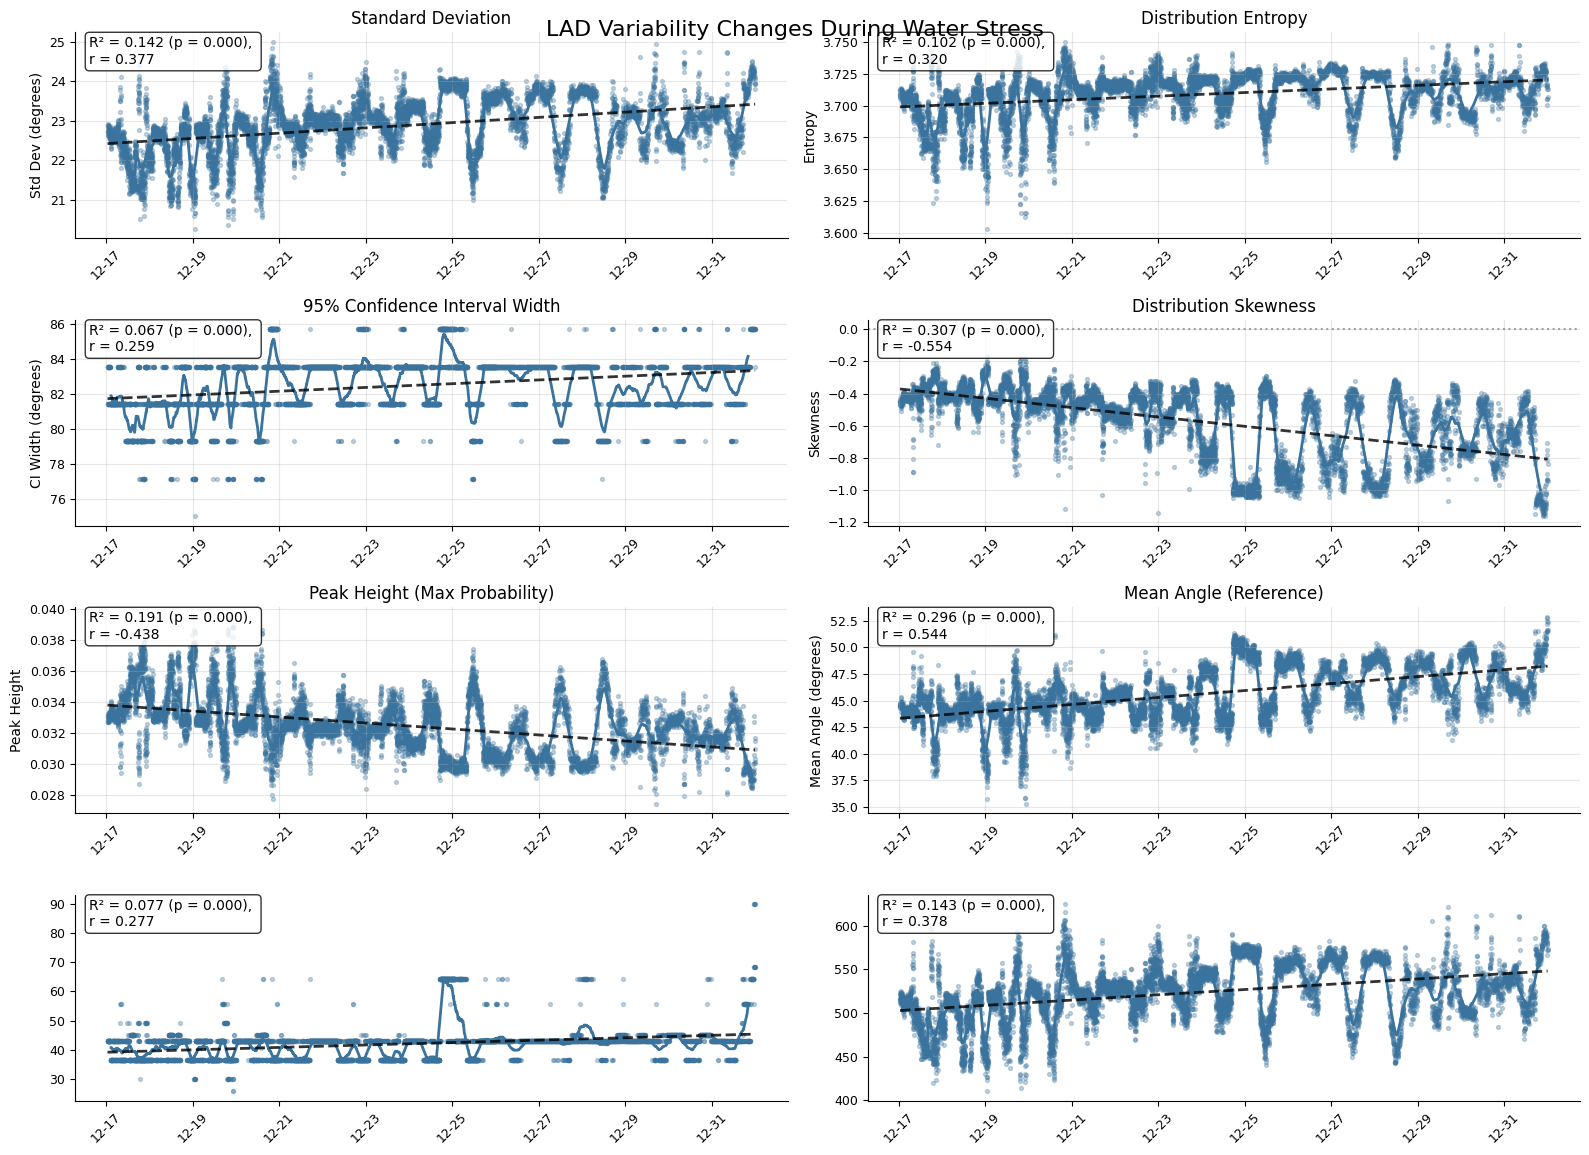

Creating LAD evolution heatmap...
Processing 8783 predictions for heatmap...
Sampled to 147 points for visualization
Created distribution matrix: (43, 147)
LAD evolution heatmap saved to: /mnt/data/lk1167/projects/AngleCamV2/data/figures/results/aglaonema_lad_evolution_heatmap.png


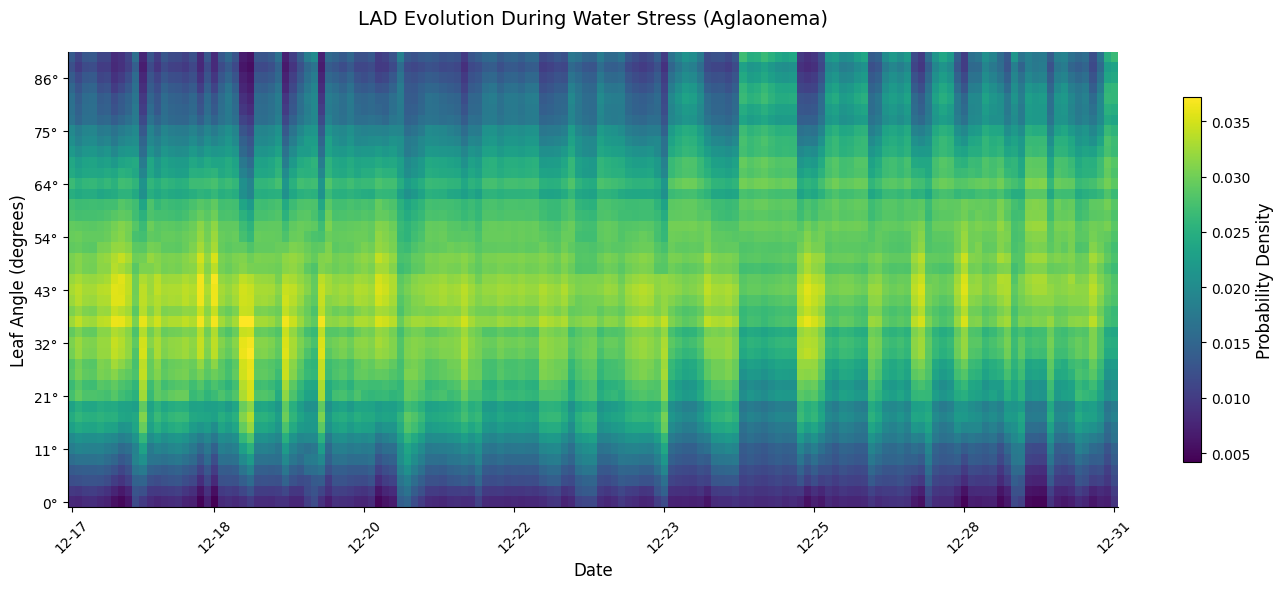


=== LAD Variability Summary ===
Standard deviation trend: 23.03 → 23.97
Entropy trend: 3.712 → 3.723
CI width trend: 82.7° → 84.4°


In [22]:
# Create variability time series plots
print("Creating variability time series plots...")
plot_lad_variability_time_series(variability_df, FIGURE_OUTPUT_DIR)

# Create distribution evolution heatmap
print("Creating LAD evolution heatmap...")
plot_distribution_evolution_heatmap(aglaonema_results, FIGURE_OUTPUT_DIR)

# Print summary statistics
print("\n=== LAD Variability Summary ===")
print(f"Standard deviation trend: {variability_df['std_dev'].iloc[-1000:].mean():.2f} → {variability_df['std_dev'].iloc[-100:].mean():.2f}")
print(f"Entropy trend: {variability_df['entropy'].iloc[-1000:].mean():.3f} → {variability_df['entropy'].iloc[-100:].mean():.3f}")
print(f"CI width trend: {variability_df['ci_width'].iloc[-1000:].mean():.1f}° → {variability_df['ci_width'].iloc[-100:].mean():.1f}°")

# Save variability data for further analysis
# variability_output_path = TESTING_RESULTS_DIR / "aglaonema_variability_analysis.csv"
# variability_df.to_csv(variability_output_path, index=False)
# print(f"Variability data saved to: {variability_output_path}")